# Image captioning with visual attention
- Ανδρέας Ευαγγελάτος - el18069
- Παναγιώτα-Νικολέττα Μπάρμπα - el18604
- Νικόλας Τασιόπουλος - el18858

The model architecture built in this tutorial is shown below. Features are extracted from the image, and passed to the cross-attention layers of the Transformer-decoder.

<table>
<tr>
  <th>The model architecture</th>
</tr>
<tr>
  <td>
   <img width=400 src="https://tensorflow.org/images/tutorials/transformer/ImageCaptioning.png"/>
  </td>
</tr>
</table>

## Setup

In [ ]:
# all imports and pip installs 
# pip installs
# pip install doesnt seem to matter in kaggle , also use P100 since it is better.
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2
# if run in kaggle use -y commnad to upper code
!pip uninstall -y tensorflow estimator keras
!pip install -U tensorflow tensorflow_datasets
!pip install einops
# imports
import concurrent.futures
import collections
import dataclasses
import hashlib
import itertools
import json
import math
import os
import pathlib
import random
import re
import string
import time
import urllib.request

import einops
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import requests
import tqdm

import tensorflow as tf
import tensorflow_hub as hub
# import tensorflow_text as text
import tensorflow_datasets as tfds
# our imports
import nltk
from nltk.translate.bleu_score import SmoothingFunction

# The Dataset

In [5]:
GetItFromGoogleDrive = False
FilesAlreadyDownloaded = False

if GetItFromGoogleDrive:
    from google.colab import drive
    drive.mount('/content/drive')
    GOOGLE_PATH = '/content/drive/MyDrive/DS/'


In [6]:
if GetItFromGoogleDrive or FilesAlreadyDownloaded:
    path = GOOGLE_PATH + 'captions_new.csv' if GetItFromGoogleDrive else './captions_new.csv'
    import csv
    captions = []
    with open(path, 'r') as captions_file:
        csvreader = csv.reader(captions_file)
        #captions = ((fname.split('#')[0], caption) for (fname, caption) in (line[0].split('\t') for line in csvreader))
        for row in csvreader:
            split_data = row[0].split('\t')
            file_name, label = split_data[0].split('#')
            # description = split_data[1].rstrip('.') # the rstrip removes the ending dot if there is one
            description = split_data[1] 
            captions.append((file_name, description))
else:
    # if image_dir already exists, skip download
    if not os.path.exists("./image_dir/"):
        # Download image files
        image_zip = tf.keras.utils.get_file('flickr30k-images-ecemod.zip',
                                            cache_subdir=os.path.abspath('.'),
                                            origin='https://spartacus.1337.cx/flickr-mod/flickr30k-images-ecemod.zip',
                                            extract=True)
        os.remove(image_zip)

In [7]:
if GetItFromGoogleDrive or FilesAlreadyDownloaded:
  # JUST TO SEE THE FORM OF THE DATA
  from itertools import islice
  for r in islice(captions,5):
    print(r)
else:
  
  print("Nothing to see here since you are not using the google drive")

Nothing to see here since you are not using the google drive


In [8]:
if GetItFromGoogleDrive or FilesAlreadyDownloaded:
  from pathlib import Path
  cap_dict = collections.defaultdict(list)
  for fname, cap in captions:
    cap_dict[fname].append(cap)
  #take the path to train and test files
  path = GOOGLE_PATH if GetItFromGoogleDrive else './'
  train_files_path = Path(path + 'train_files.csv')
  test_files_path = Path(path+'test_files.csv')

  train_files = (train_files_path ).read_text().splitlines()
  train_captions = [(str(path+'image_dir/'+fname), cap_dict[fname]) for fname in train_files]
    
  test_files = (test_files_path).read_text().splitlines()
  test_captions = [(str(path+'image_dir/'+fname), cap_dict[fname]) for fname in test_files]
    
  train_raw = tf.data.experimental.from_list(train_captions)
  test_raw = tf.data.experimental.from_list(test_captions)
else:
  # Download captions file
  captions_file = tf.keras.utils.get_file('captions_new.csv',
                                            cache_subdir=os.path.abspath('.'),
                                            origin='https://spartacus.1337.cx/flickr-mod/captions_new.csv',
                                            extract=False)

  # Download train files list
  train_files_list = tf.keras.utils.get_file('train_files.csv',
                                            cache_subdir=os.path.abspath('.'),
                                            origin='https://spartacus.1337.cx/flickr-mod/train_files.csv',
                                            extract=False)

  # Download test files list
  test_files_list = tf.keras.utils.get_file('test_files.csv',
                                            cache_subdir=os.path.abspath('.'),
                                            origin='https://spartacus.1337.cx/flickr-mod/test_files.csv',
                                            extract=False)
  path="."
  IMAGE_DIR="image_dir"
  path = pathlib.Path(path)
    
  captions = (path/captions_file).read_text().splitlines()
  captions = (line.split('\t') for line in captions)
  captions = ((fname.split('#')[0], caption) for (fname, caption) in captions)
    
  cap_dict = collections.defaultdict(list)
  for fname, cap in captions:
    cap_dict[fname].append(cap)
    
  train_files = (path/train_files_list).read_text().splitlines()
  train_captions = [(str(path/IMAGE_DIR/fname), cap_dict[fname]) for fname in train_files]
    
  test_files = (path/test_files_list).read_text().splitlines()
  test_captions = [(str(path/IMAGE_DIR/fname), cap_dict[fname]) for fname in test_files]
    
  train_raw = tf.data.experimental.from_list(train_captions)
  test_raw = tf.data.experimental.from_list(test_captions)
  

In [9]:
train_raw.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(5,), dtype=tf.string, name=None))

In [10]:
for ex_path, ex_captions in train_raw.take(1):
  print(ex_path)
  print(ex_captions)

tf.Tensor(b'image_dir/_3430497.jpg', shape=(), dtype=string)
tf.Tensor(
[b'The skier is wearing a yellow jumpsuit and sliding across a yellow rail .'
 b'A yellow uniformed skier is performing a trick across a railed object .'
 b'A skier in electric green on the edge of a ramp made of metal bars .'
 b'A person on skis on a rail at night .'
 b'A skier slides along a metal rail .'], shape=(5,), dtype=string)


### Image feature extractor

In [11]:
IMAGE_SHAPE=(224, 224, 3)
mobilenet = tf.keras.applications.MobileNetV3Small(
    input_shape=IMAGE_SHAPE,
    include_top=False,
    include_preprocessing=True)
mobilenet.trainable=False

In [12]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SHAPE[:-1])
    return img

In [13]:
test_img_batch = load_image(ex_path)[tf.newaxis, :]

print(test_img_batch.shape)
print(mobilenet(test_img_batch).shape)

(1, 224, 224, 3)
(1, 7, 7, 576)


### Text Tokenizer/Vectorizer


In [14]:
def standardize(s):
  s = tf.strings.lower(s)
  s = tf.strings.regex_replace(s, f'[{re.escape(string.punctuation)}]', '')
  s = tf.strings.join(['[START]', s, '[END]'], separator=' ')
  return s

In [15]:
# Use the top 5000 words for a vocabulary.
vocabulary_size = 5000
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    ragged=True)
# Learn the vocabulary from the caption data.

In [16]:
tokenizer.adapt(train_raw.map(lambda fp,txt: txt).unbatch().batch(1024))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [17]:
tokenizer.get_vocabulary()[:10]

['', '[UNK]', 'a', '[START]', '[END]', 'in', 'the', 'on', 'and', 'man']

In [18]:
t = tokenizer([['a cat in a hat'], ['a robot dog']])
t

<tf.RaggedTensor [[3, 2, 755, 5, 2, 63, 4], [3, 2, 2866, 34, 4]]>

In [19]:
# Create mappings for words to indices and indices to words.
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

In [20]:
t = t.to_tensor()
print(t)
w = index_to_word(t)
# w.to_list()

tf.Tensor(
[[   3    2  755    5    2   63    4]
 [   3    2 2866   34    4    0    0]], shape=(2, 7), dtype=int64)


In [21]:
tf.strings.reduce_join(w, separator=' ', axis=-1).numpy()

array([b'[START] a cat in a hat [END]', b'[START] a robot dog [END]  '],
      dtype=object)

### Prepare the datasets

In [22]:
def match_shapes(images, captions):
  caption_shape = einops.parse_shape(captions, 'b c')
  captions = einops.rearrange(captions, 'b c -> (b c)')
  images = einops.repeat(
      images, 'b ... -> (b c) ...',
      c = caption_shape['c'])
  return images, captions

In [23]:
for ex_paths, ex_captions in train_raw.batch(32).take(1):
  break

print('image paths:', ex_paths.shape)
print('captions:', ex_captions.shape)
print()

ex_paths, ex_captions = match_shapes(images=ex_paths, captions=ex_captions)

print('image_paths:', ex_paths.shape)
print('captions:', ex_captions.shape)


image paths: (32,)
captions: (32, 5)

image_paths: (160,)
captions: (160,)


In [24]:
def prepare_txt(imgs, txts):
  tokens = tokenizer(txts)

  input_tokens = tokens[..., :-1]
  label_tokens = tokens[..., 1:]
  return (imgs, input_tokens), label_tokens

In [25]:
def prepare_dataset(ds, tokenizer, batch_size=32, shuffle_buffer=1000):
  # Load the images and make batches.
  ds = (ds
        .shuffle(10000)
        .map(lambda path, caption: (load_image(path), caption))
        .apply(tf.data.experimental.ignore_errors())
        .batch(batch_size))

  def to_tensor(inputs, labels):
    (images, in_tok), out_tok = inputs, labels
    return (images, in_tok.to_tensor()), out_tok.to_tensor()
  def prepare_txt(imgs, txts):
    tokens = tokenizer(txts)

    input_tokens = tokens[..., :-1]
    label_tokens = tokens[..., 1:]
    return (imgs, input_tokens), label_tokens
  return (ds
          .map(match_shapes, tf.data.AUTOTUNE)
          .unbatch()
          .shuffle(shuffle_buffer)
          .batch(batch_size)
          .map(prepare_txt, tf.data.AUTOTUNE) # should be parameterized by the tokenizer
          .map(to_tensor, tf.data.AUTOTUNE)
          )

In [26]:
train_ds = prepare_dataset(train_raw, tokenizer)
train_ds.element_spec

Instructions for updating:
Use `tf.data.Dataset.ignore_errors` instead.


((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

In [27]:
# Image loaded in train_ds can be passed to Ecoders 

for (image, in_tok), out_tok in train_ds.take(1):
  break

print(image.shape) # Αναμένπυμε (batch_size, 224, 224, 3)
print(in_tok.shape)
print(in_tok)
print(out_tok.shape)

(32, 224, 224, 3)
(32, 19)
tf.Tensor(
[[   3   14  156  100   15   33  137    7    2 1265    0    0    0    0
     0    0    0    0    0]
 [   3    2   58    7    2   98   78   46    2  295   80  205    0    0
     0    0    0    0    0]
 [   3  109  202 1713   43  162    2  317    0    0    0    0    0    0
     0    0    0    0    0]
 [   3    2  156   13    5    2   27   74   10  120    7   41  297    5
    39   11    2   77    0]
 [   3    6  316    5   27   10   49  337   64   26   28   66    0    0
     0    0    0    0    0]
 [   3   43    9  117   76    9    1    5    2 1666    1  518    7    2
   671  224    0    0    0]
 [   3    2 1085  129   11    2 1425    8    2   58  557 2809    0    0
     0    0    0    0    0]
 [   3    2   13   40  136    2 1342    0    0    0    0    0    0    0
     0    0    0    0    0]
 [   3    2   34   10  178  545   46    2   67  350    5    6  222    0
     0    0    0    0    0]
 [   3  202   15   31    7    2    9    5    2 2257  188    0 

In [28]:
test_ds = prepare_dataset(test_raw, tokenizer)
test_ds.element_spec


((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

### Caching the image features (faster trainning)

In [29]:
def save_dataset(ds, save_path, image_model, tokenizer, shards=10, batch_size=32):
  # Load the images and make batches.
  ds = (ds
        .map(lambda path, caption: (load_image(path), caption))
        .apply(tf.data.experimental.ignore_errors())
        .batch(batch_size))

  # Run the feature extractor on each batch
  # Don't do this in a .map, because tf.data runs on the CPU. 
  def gen():
    # Εδώ τρέχει το μοντέλο πριν ξεδιπλώσει τις (1 εικόνα -> 5 captions) σε (5 εικόνες -> 5 captions)
    # για να μην το τρέξει τελικά 5 φορές για κάθε εικόνα. Έπειτα κάνει το ξεδίπλωμα.
    for (images, captions) in tqdm.tqdm(ds): 
      feature_maps = image_model(images)

      feature_maps, captions = match_shapes(feature_maps, captions)
      yield feature_maps, captions

  # Wrap the generator in a new tf.data.Dataset.
  new_ds = tf.data.Dataset.from_generator(
      gen,
      output_signature=(
          tf.TensorSpec(shape=image_model.output_shape),
          tf.TensorSpec(shape=(None,), dtype=tf.string)))


  def prepare_txt(imgs, txts):
    tokens = tokenizer(txts)

    input_tokens = tokens[..., :-1]
    label_tokens = tokens[..., 1:]
    return (imgs, input_tokens), label_tokens



  # Apply the tokenization 
  new_ds = (new_ds
            .map(prepare_txt, tf.data.AUTOTUNE)
            .unbatch()
            .shuffle(1000))
    
  # Save the dataset into shard files.
  def shard_func(i, item):
    return i % shards
  new_ds.enumerate().save(save_path, shard_func=shard_func)

def load_dataset(save_path, batch_size=32, shuffle=1000, cycle_length=2):
  def custom_reader_func(datasets):
    datasets = datasets.shuffle(1000)
    return datasets.interleave(lambda x: x, cycle_length=cycle_length)
  
  ds = tf.data.Dataset.load(save_path, reader_func=custom_reader_func)

  def drop_index(i, x):
    return x

  ds = (ds
        .map(drop_index, tf.data.AUTOTUNE)
        .shuffle(shuffle)
        .padded_batch(batch_size)
        .prefetch(tf.data.AUTOTUNE))
  return ds

In [ ]:
save_dataset(train_raw, 'train_cache', mobilenet, tokenizer)
save_dataset(test_raw, 'test_cache', mobilenet, tokenizer)

 </section>


## Data ready for training

In [ ]:
# EINAI ((FEATURE(MODEL SPECIFIC), INPUT), OUTPUT)
train_ds = load_dataset('./train_cache')
test_ds = load_dataset('./test_cache')

In [30]:
train_ds.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

In [31]:
for (inputs, ex_labels) in train_ds.take(1):
  (ex_img, ex_in_tok) = inputs

print(ex_img.shape)
print(ex_in_tok.shape)
print(ex_labels.shape)

(32, 224, 224, 3)
(32, 28)
(32, 28)


In [32]:
print(ex_in_tok[0].numpy())
print(ex_labels[0].numpy())

[   3   14 2881 2067  100 1230   16 3530    2   66   73   11  914   44
    0    0    0    0    0    0    0    0    0    0    0    0    0    0]
[  14 2881 2067  100 1230   16 3530    2   66   73   11  914   44    4
    0    0    0    0    0    0    0    0    0    0    0    0    0    0]


## Transformer decoder model


<table>
<tr>
  <th>The Transformer encoder and decoder.</th>
</tr>
<tr>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-1layer-words.png"/>
  </td>
</tr>
</table>

The model will be implemented in three main parts: 

1. Input - The token embedding and positional encoding (`SeqEmbedding`).
1. Decoder - A stack of transformer decoder layers (`DecoderLayer`) where each contains:
   1. A causal self attention later (`CausalSelfAttention`), where each output location can attend to the output so far.
   1. A cross attention layer (`CrossAttention`) where each output location can attend to the input image.
   1. A feed forward network (`FeedForward`) layer which further processes each output location independently.
1. Output - A multiclass-classification over the output vocabulary.


### Input

In [33]:
class SeqEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, max_length, depth, embeddingsLayer=None):
    super().__init__()
    # POSITION EMBEDDING INVARIANT!
    self.pos_embedding = tf.keras.layers.Embedding(input_dim=max_length, output_dim=depth)

    # this needs to be changable to change the text embeddings
    if embeddingsLayer==None:
      self.token_embedding = tf.keras.layers.Embedding(
          input_dim=vocab_size,
          output_dim=depth,
          mask_zero=True)
    else:
      self.token_embedding = embeddingsLayer
    self.add = tf.keras.layers.Add()

  def call(self, seq):
    seq = self.token_embedding(seq) # (batch, seq, depth)
    # print(f'Output from embeddings shape {seq.shape}')
    x = tf.range(tf.shape(seq)[1])  # (seq)
    x = x[tf.newaxis, :]  # (1, seq)
    x = self.pos_embedding(x)  # (1, seq, depth)

    return self.add([seq,x])

### Decoder

In [34]:
class CausalSelfAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    # Use Add instead of + so the keras mask propagates through.
    self.add = tf.keras.layers.Add() 
    self.layernorm = tf.keras.layers.LayerNormalization()
  
  def call(self, x):
    attn = self.mha(query=x, value=x,
                    use_causal_mask=True)
    x = self.add([x, attn])
    return self.layernorm(x)


In [35]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self,**kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.add = tf.keras.layers.Add() 
    self.layernorm = tf.keras.layers.LayerNormalization()
  
  def call(self, x, y, **kwargs):
    attn, attention_scores = self.mha(
             query=x, value=y,
             return_attention_scores=True)
    
    self.last_attention_scores = attention_scores

    x = self.add([x, attn])
    return self.layernorm(x)

In [36]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, units, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
        tf.keras.layers.Dense(units=2*units, activation='relu'),
        tf.keras.layers.Dense(units=units),
        tf.keras.layers.Dropout(rate=dropout_rate),
    ])

    self.layernorm = tf.keras.layers.LayerNormalization()
  
  def call(self, x):
    x = x + self.seq(x)
    return self.layernorm(x)


In [37]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, units, num_heads=1, dropout_rate=0.1):
    super().__init__()
    
    self.self_attention = CausalSelfAttention(num_heads=num_heads,
                                              key_dim=units,
                                              dropout=dropout_rate)
    self.cross_attention = CrossAttention(num_heads=num_heads,
                                          key_dim=units,
                                          dropout=dropout_rate)
    self.ff = FeedForward(units=units, dropout_rate=dropout_rate)
      

  def call(self, inputs, training=False):
    in_seq, out_seq = inputs

    # Text input
    out_seq = self.self_attention(out_seq)

    out_seq = self.cross_attention(out_seq, in_seq)
    
    self.last_attention_scores = self.cross_attention.last_attention_scores

    out_seq = self.ff(out_seq)

    return out_seq

### Output

In [38]:
#@title
class TokenOutput(tf.keras.layers.Layer):
  def __init__(self, tokenizer, banned_tokens=('', '[UNK]', '[START]'), **kwargs):
    super().__init__()
    
    self.dense = tf.keras.layers.Dense(
        units=tokenizer.vocabulary_size(), **kwargs)
    self.tokenizer = tokenizer
    self.banned_tokens = banned_tokens

    self.bias = None

  def adapt(self, ds):
    counts = collections.Counter()
    # token -> word
    vocab_dict = {name: id 
                  for id, name in enumerate(self.tokenizer.get_vocabulary())}
    # gets counts of token appearing in the dataset.
    for tokens in tqdm.tqdm(ds):
      counts.update(tokens.numpy().flatten())

    counts_arr = np.zeros(shape=(self.tokenizer.vocabulary_size(),))
    counts_arr[np.array(list(counts.keys()), dtype=np.int32)] = list(counts.values())

    counts_arr = counts_arr[:]
    for token in self.banned_tokens:
      counts_arr[vocab_dict[token]] = 0

    total = counts_arr.sum()
    p = counts_arr/total
    p[counts_arr==0] = 1.0
    log_p = np.log(p)  # log(1) == 0

    entropy = -(log_p*p).sum()

    print()
    print(f"Uniform entropy: {np.log(self.tokenizer.vocabulary_size()):0.2f}")
    print(f"Marginal entropy: {entropy:0.2f}")

    self.bias = log_p
    self.bias[counts_arr==0] = -1e9

  def call(self, x):
    # print('x In output layer is: ', x.shape)
    x = self.dense(x)
    return x + self.bias


In [122]:
# Output layer better initialization
output_layer = TokenOutput(tokenizer, banned_tokens=('', '[UNK]', '[START]'))
output_layer.adapt(train_ds.map(lambda inputs, labels: labels))

3282it [01:08, 48.11it/s]


Uniform entropy: 8.52
Marginal entropy: 5.47


### The model

In [39]:
class Captioner(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, tokenizer, feature_extractor, output_layer, num_layers=1,
               units=256, max_length=50, num_heads=1, dropout_rate=0.1, embeddings=None):
    super().__init__()
    self.feature_extractor = feature_extractor
    self.tokenizer = tokenizer
    # λέξη σε token
    self.word_to_index = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=tokenizer.get_vocabulary())
    # token σε λέξη
    self.index_to_word = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=tokenizer.get_vocabulary(),
        invert=True) 
    
    # πρώτο layer εμφυτεύματα + πληροφορίες τοποθεσίας
    if embeddings is None:
        self.seq_embedding = SeqEmbedding(
            vocab_size=tokenizer.vocabulary_size(),
            depth=units,
            max_length=max_length)
    else:
        self.seq_embedding = SeqEmbedding(
            vocab_size=tokenizer.vocabulary_size(),
            depth=units,
            max_length=max_length, 
            embeddingsLayer=embeddings
            )
    
    # decoder layers
    self.decoder_layers = [
        DecoderLayer(units, num_heads=num_heads, dropout_rate=dropout_rate)
        for n in range(num_layers)]
    
    # final prediction layer
    self.output_layer = output_layer

In [40]:
  @Captioner.add_method
  def call(self, inputs):
    image, txt = inputs

    if image.shape[-1] == 3:
      # Apply the feature-extractor, if you get an RGB image.
      image = self.feature_extractor(image)
    
    # Flatten the feature map
    image = einops.rearrange(image, 'b h w c -> b (h w) c')


    if txt.dtype == tf.string:
      # Apply the tokenizer if you get string inputs.
      txt = tokenizer(txt)

    txt = self.seq_embedding(txt)

    # Look at the image
    for dec_layer in self.decoder_layers:
      txt = dec_layer(inputs=(image, txt))
      
    txt = self.output_layer(txt)

    return txt

The Default Model

In [124]:
model = Captioner(tokenizer, feature_extractor=mobilenet, output_layer=output_layer,
                  units=256, dropout_rate=0.5, num_layers=2, num_heads=2)

### Functions for Generating captions

In [41]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_path = tf.keras.utils.get_file('surf.jpg', origin=image_url)
image = load_image(image_path)

In [42]:
@Captioner.add_method
def simple_gen(self, image, temperature=1):
  initial = self.word_to_index([['[START]']]) # (batch, sequence)
  img_features = self.feature_extractor(image[tf.newaxis, ...])

  tokens = initial # (batch, sequence)
  for n in range(50):
    preds = self((img_features, tokens)).numpy()  # (batch, sequence, vocab)
    preds = preds[:,-1, :]  #(batch, vocab)
    if temperature==0:
        next = tf.argmax(preds, axis=-1)[:, tf.newaxis]  # (batch, 1)
    else:
        next = tf.random.categorical(preds/temperature, num_samples=1)  # (batch, 1)
    tokens = tf.concat([tokens, next], axis=1) # (batch, sequence) 

    if next[0] == self.word_to_index('[END]'):
      break
  words = index_to_word(tokens[0, 1:-1])
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  return result.numpy().decode()

In [43]:
## Faster simple_gen works on an entire batch

def from_tokens_batched_to_list_of_string(tokens, word_to_index, start=1):

    end_tokens = tf.map_fn(lambda l: tf.where(l==word_to_index('[END]'))[0], tokens, dtype=tf.int64)
    end_positions = end_tokens[:, 0] # (32, )
    words = (index_to_word(tokens))
    words = words.numpy()
    end_positions = end_positions.numpy()
    words = (list(map(lambda x : list((x[0])[1:x[1]]), zip(words, end_positions))))
    words = list(map(lambda l: map(lambda x: x.decode(), l), words))
    words = list(map(lambda x : " ".join(x), words))
    return words


@Captioner.add_method
def simple_gen_batched(self, image, temperature=1):
  initial = self.word_to_index([['[START]']] * image.shape[0]) # (batch, sequence)
  # img_features = self.feature_extractor(image[tf.newaxis, ...])
  img_features = image

  tokens = initial # (batch, sequence)
  for n in range(50):
    preds = self((img_features, tokens)).numpy()  # (batch, sequence, vocab)
    preds = preds[:,-1, :]  #(batch, vocab)
    if temperature==0:
        next = tf.argmax(preds, axis=-1)[:, tf.newaxis]  # (batch, 1)
    else:
        next = tf.random.categorical(preds/temperature, num_samples=1)  # (batch, 1)
    tokens = tf.concat([tokens, next], axis=1) # (batch, sequence) 

    tokens2 = tokens.numpy()
    if all(map(lambda l: self.word_to_index('[END]') in l, tokens2)):
      break
  end_to_append = [[self.word_to_index('[END]')]] * img_features.shape[0]
  tokens = tf.concat([tokens, end_to_append], axis=1)
  
  words = from_tokens_batched_to_list_of_string(tokens, self.word_to_index)
  
  return words

In [ ]:
for t in (0.0, 0.5, 1.0):
  result = model.simple_gen(image, temperature=t)
  print(result)
# The model is untrained this should be random

### Generating Captions Beam Search

In [49]:
@Captioner.add_method
def simple_gen_beam_search(self, image, beam_size=2):
  initial = self.word_to_index([['[START]']])                        # 'START' token == 3
  img_features = self.feature_extractor(image[tf.newaxis, ...])      # extract features from image

  tokens_list = [(initial, 0.0)]                  # list of tuples (tokens, propability): stores the top b sentences for each branch (in each iteration)
  final_tokens_list = []                          # list of tuples (tokens, propability): final top b selected sentences

  remaining_beam_size = beam_size                 # Counter for how many branches in the beam search tree have not terminated yet
  for n in range(50):
    if remaining_beam_size == 0:
      break
    new_tokens_list = []                          # top_b tokens for each branch (b*b tokens)
    for tokens, prob in tokens_list:              # tokens: [3, 15, 22, 10, ...], prob: float (ex. 0.23)
      if tokens[0][-1] == self.word_to_index('[END]'):
        remaining_beam_size -= 1
        final_tokens_list.append((tokens, prob))
        continue
      preds = self((img_features, tokens)).numpy()    # generate probabilities for all words given a sentence 'tokens' and an image 'img_features'
      preds = preds[:, -1, :]                         # get the probabilities vector only for the last word
      top_b_preds = tf.math.top_k(preds, k=remaining_beam_size) # get the b words with the biggest probability
      top_b_tokens = top_b_preds.indices              # tokens 
      top_b_prob = top_b_preds.values                 # probabilities
      for i in range(remaining_beam_size):
        next_token = [[top_b_tokens[0][i]]]           # next token to be added to the sentence (in one branch)
        new_tokens = tf.concat([tokens, next_token], axis=1)
        new_log_prob = prob + top_b_prob[0][i]
        new_tokens_list.append((new_tokens, new_log_prob))
      
    tokens_list = sorted(new_tokens_list, key=lambda x: -x[1])[:remaining_beam_size] # Sort the list with b*b sentences and keep the first b

  # Return the sentence with the biggest (probability / sentence length) score
  tokens, prob = max(final_tokens_list, key=lambda x: x[1]/len(x[0][0, 1:-1]))
  words = index_to_word(tokens[0, 1:-1])
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  
  return result.numpy().decode()

## Train

### Losses and metrics

In [50]:
def masked_loss(labels, preds):
  # (y_true, y_pred)  
  # ([y_1, y_2, ..., y_k, 0, 0, ...], [[prob distr for y_1], [prob_distr for y_2], ..., [prob distr for y_l], [prob distr for y_{l+1}], ...])
  
  loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels, preds)

  mask = (labels != 0) & (loss < 1e8) 
  mask = tf.cast(mask, loss.dtype)
  
  loss = loss*mask
  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss

def masked_acc(labels, preds):
  mask = tf.cast(labels!=0, tf.float32)
  preds = tf.argmax(preds, axis=-1) # -10 < 10 <==> e^{-10} < e^{10} <==> e^{-10} / sum < e^{-10} / sum <==> probability(loc(-10)) < probability(loc(10))
  labels = tf.cast(labels, tf.int64)
  match = tf.cast(preds == labels, mask.dtype)
  acc = tf.reduce_sum(match*mask)/tf.reduce_sum(mask)
  return acc

### BLEU score evaluation functions


In [75]:
weights = (0.4, 0.3, 0.2, 0.1)
smoothing_function = SmoothingFunction().method1

def sentence_bleu_calc(references, hyp):
  return(nltk.translate.bleu_score.sentence_bleu(
                                          references, 
                                          hyp, 
                                          weights = weights, 
                                          smoothing_function=smoothing_function))
def corpus_bleu_calc(list_of_references, list_of_hypotheses):
  return(nltk.translate.bleu_score.corpus_bleu(list_of_references, 
                                               list_of_hypotheses, 
                                               weights = weights, 
                                               smoothing_function=smoothing_function))

In [76]:
#BLEU SCORE Callback Class
class BLEUScoreClass(tf.keras.callbacks.Callback):
    def __init__(self, test_data, model):
        super().__init__()
        self.test_data = test_data
        self.model = model
        self.logs = {}
    #
    # Beam Search Generation and evaluation with bleu score
    #
    def produce_hyp_and_ref_bs(self, SPECIFIC_TEST_DATA=None):
      refs = []        
      hyp = []        
      for imagePath, labels in tqdm.tqdm(self.test_data if not SPECIFIC_TEST_DATA else SPECIFIC_TEST_DATA):          
        # load the image from its path          
        image = load_image(imagePath)          
        # here the best temperature for the bleu score is 0
        # remove '.' so we take out the last word.
        try:          
          generated_caption = self.model.simple_gen_beam_search(image).split(' ') 
        except:
          generated_caption = ['.']
        # check if the generated caption has . as the last word          
        if generated_caption[-1] == '.':            
          generated_caption = generated_caption[:-1]          
        # generate the references          
        words = []          
        for word in labels:            
          valid_words = word.split(' ')            
          if valid_words[-1] == '.':              
            valid_words = valid_words[:-1]            
          words.append(valid_words)          
        # append the references and the generated caption          
        refs.append(words)          
        hyp.append(generated_caption)        
      return refs, hyp
    def corpus_bleu_bs(self, nameId='default'):
        nsamples = 1000

        refs, hyp = self.produce_hyp_and_ref_bs(self.test_data[:nsamples])
        # Compute BLEU score
        score = corpus_bleu_calc (refs, hyp)
        self.logs[f'BLEU_score-1k-{nameId}'] = score
        return score
    # 
    # End of Beam Search Seciton
    #


    #
    # Simple Gen Temperature Generation but batched 
    #
    def produce_hyp_and_ref_new(self, img, captions):
        # (batch, image_features), (batch, captions)
        img_features = self.model.feature_extractor(img)
        predictions = self.model.simple_gen_batched(img_features, temperature=0)
        predictions = list(map(lambda x: x.split(' '), predictions))

        
        captions = list(map(lambda group_of_captions: list(map(lambda caption: caption.decode().split(' '), group_of_captions)), captions.numpy()))
        
        
        return captions, predictions
    
    
    def calculate_bleu_score_batched(self, ds, nameId='default'):
        # ONE_KILO_SAMPLES = 1000
        total_refs = []
        total_hyp  = []
        count = 0
        def prepare_dataset_2(ds, tokenizer, batch_size=32, shuffle_buffer=1000):
        # Load the images and make batches.
          ds = (ds
                .shuffle(10000)
                .map(lambda path, caption: ((load_image(path)), caption))
                .apply(tf.data.experimental.ignore_errors())
                .batch(batch_size))
          return ds

        # 32 batch size and 32 batches is 1024 images
        for img_features, captions in tqdm.tqdm(prepare_dataset_2(ds, self.model.tokenizer).take(32)):
          refs, hyp = self.produce_hyp_and_ref_new(img_features, captions)
          for i in refs:
            count += 1
            total_refs.append(i)
          for i in hyp:
            total_hyp.append(i)
        print(f'Count is {count}')
        score = corpus_bleu_calc (total_refs, total_hyp)
        self.logs[f'BLEU_score-1k-{nameId}'] = score
        return score
    #
    # End of Batch Generation and evaluation
    #



    def produce_hyp_and_ref(self, SPECIFIC_TEST_DATA=None):        
      refs = []        
      hyp = []        
      for imagePath, labels in tqdm.tqdm(self.test_data if not SPECIFIC_TEST_DATA else SPECIFIC_TEST_DATA):          
        # load the image from its path          
        image = load_image(imagePath)          
        # here the best temperature for the bleu score is 0
        # remove '.' so we take out the last word.          
        generated_caption = self.model.simple_gen(image, temperature =0).split(' ')          
        # check if the generated caption has . as the last word          
        if generated_caption[-1] == '.':            
          generated_caption = generated_caption[:-1]          
          # generate the references          
        words = []          
        for word in labels:            
          valid_words = word.split(' ')            
          if valid_words[-1] == '.':              
            valid_words = valid_words[:-1]            
          words.append(valid_words)          
        # append the references and the generated caption          
        refs.append(words)          
        hyp.append(generated_caption)        
      return refs, hyp

    
    def on_epoch_end(self, epoch, logs=None):
        # Compute BLEU score on validation data
        NUMBER_OF_SAMPLES = 20
        refs, hyp = self.produce_hyp_and_ref(self.test_data[:NUMBER_OF_SAMPLES], loadTheImage=True)
        # Compute BLEU score
        score = corpus_bleu_calc (refs, hyp)
        # here i remove
        logs = logs or {}
        logs[f'BLEU_score-[{epoch}]'] = score
        # Log BLEU score
        self.logs[f'BLEU_score-[{epoch}]'] = score
        print(f"BLEU score: {score:.4f}")


### Callback for Sample Generation

In [53]:
class GenerateText(tf.keras.callbacks.Callback):
  def __init__(self):
    image_url = 'https://tensorflow.org/images/surf.jpg'
    image_path = tf.keras.utils.get_file('surf.jpg', origin=image_url)
    self.image = load_image(image_path)

  def on_epoch_end(self, epochs=None, logs=None):
    print()
    print()
    for t in (0.0, 0.5, 1.0):
      result = self.model.simple_gen(self.image, temperature=t)
      print(result)
    print()


In [ ]:
g = GenerateText()
g.model = model
g.on_epoch_end(0)

In [125]:
callbacks = [
    GenerateText(),
    tf.keras.callbacks.EarlyStopping(
        patience=5, restore_best_weights=True)] # !! Might stop before it reaches the number of epocsh

### Default Train

In [126]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
           loss=masked_loss,
           metrics=[masked_acc,], )

In [127]:
history = model.fit(
    train_ds.repeat(),
    steps_per_epoch=100,
    validation_data=test_ds.repeat(),
    validation_steps=20,
    epochs=100,
    callbacks=callbacks)

Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 5.2386 - masked_acc: 0.1854

a man in a man in a man in a
a man in a a his on a man of a in a man
a a is little wearing near

100/100 [==============================] - 35s 207ms/step - loss: 5.2386 - masked_acc: 0.1854 - val_loss: 4.9700 - val_masked_acc: 0.2144
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 4.8934 - masked_acc: 0.2300

a man in a white shirt is in a white
a man is on the
a man with a sunny while street

100/100 [==============================] - 11s 110ms/step - loss: 4.8934 - masked_acc: 0.2300 - val_loss: 4.7164 - val_masked_acc: 0.2510
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 4.6945 - masked_acc: 0.2529

a man in a white shirt is in a white dog
a man in a the outdoor in a man is playing a white field
a with for a black umbrella of a stand

100/100 [==============================] - 11s 114ms/step - loss: 4.6945 - masked_acc: 0.2529 - val_los

In [141]:
bleuScore = BLEUScoreClass(test_data=(test_captions), model=model)
bleuScore.model = model
bleuScore.test_data = test_raw
bleuScore.calculate_bleu_score_batched(test_raw, nameId='Default')
print(bleuScore.logs)

32it [02:49,  5.30s/it]


Count is 1024
{'BLEU_score-1k-Default': 0.15722381458212337}


In [140]:
from google.colab import files
files.download('/content/BestModel.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

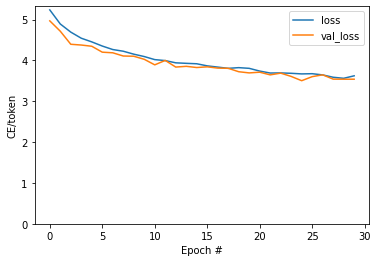

In [142]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

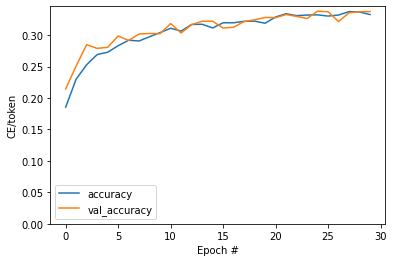

In [143]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

## Attention plots

In [144]:
result = model.simple_gen(image, temperature=0.0)
result

'a man in a red shirt is swimming pool'

In [145]:
str_tokens = result.split()
str_tokens.append('[END]')

The `DecoderLayers` each cache the attention scores for their `CrossAttention` layer. The shape of each attention map is `(batch=1, heads, sequence, image)`:

In [146]:
attn_maps = [layer.last_attention_scores for layer in model.decoder_layers]
[map.shape for map in attn_maps]

[TensorShape([1, 2, 10, 49]), TensorShape([1, 2, 10, 49])]

So stack the maps along the `batch` axis, then average over the `(batch, heads)` axes, while splitting the `image` axis back into `height, width`:


In [147]:
attention_maps = tf.concat(attn_maps, axis=0)
attention_maps = einops.reduce(
    attention_maps,
    'batch heads sequence (height width) -> sequence height width',
    height=7, width=7,
    reduction='mean')

Now you have a single attention map, for each sequence prediction. The values in each map should sum to `1.`

In [148]:
einops.reduce(attention_maps, 'sequence height width -> sequence', reduction='sum')

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)>

So here is where the model was focusing attention while generating each token of the output:

In [149]:
def plot_attention_maps(image, str_tokens, attention_map):
    fig = plt.figure(figsize=(16, 9))

    len_result = len(str_tokens)
    
    titles = []
    for i in range(len_result):
      map = attention_map[i]
      grid_size = max(int(np.ceil(len_result/2)), 2)
      ax = fig.add_subplot(3, grid_size, i+1)
      titles.append(ax.set_title(str_tokens[i]))
      img = ax.imshow(image)
      ax.imshow(map, cmap='gray', alpha=0.6, extent=img.get_extent(),
                clim=[0.0, np.max(map)])

    plt.tight_layout()

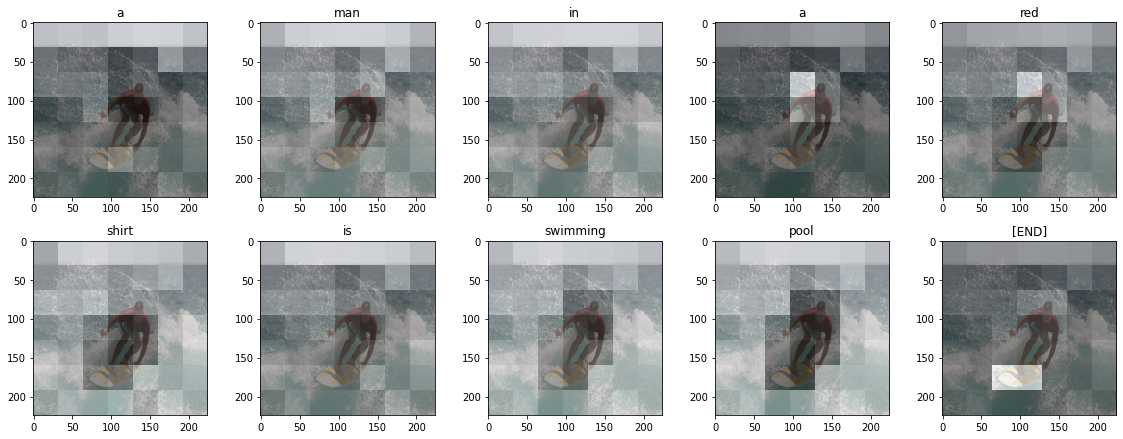

In [150]:
plot_attention_maps(image/255, str_tokens, attention_maps)

Now put that together into a more usable function:

In [152]:
@Captioner.add_method
def run_and_show_attention(self, image, temperature=0.0):
  result_txt = self.simple_gen(image, temperature)
  str_tokens = result_txt.split()
  str_tokens.append('[END]')

  attention_maps = [layer.last_attention_scores for layer in self.decoder_layers]
  attention_maps = tf.concat(attention_maps, axis=0)
  attention_maps = einops.reduce(
      attention_maps,
      'batch heads sequence (height width) -> sequence height width',
      height=7, width=7,
      reduction='mean')
  
  plot_attention_maps(image/255, str_tokens, attention_maps)
  t = plt.suptitle(result_txt)
  t.set_y(1.05)


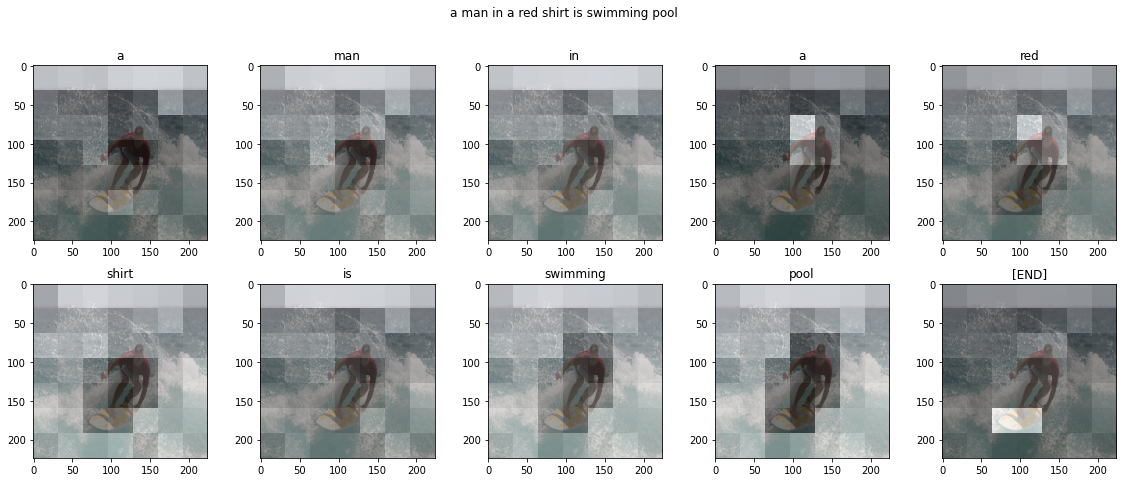

In [153]:
run_and_show_attention(model, image)

# More Training

In [ ]:
# blue socre class
bleuScore = BLEUScoreClass(test_data=(test_captions), model=model)

## Encoders


In [55]:
# Define the image shape
IMAGE_SHAPE = (224, 224, 3)

# Load the encoders
vgg16 = tf.keras.applications.VGG16(input_shape=IMAGE_SHAPE, include_top=False,weights='imagenet' )
vgg19 = tf.keras.applications.VGG19(input_shape=IMAGE_SHAPE, include_top=False, weights='imagenet')
resnet50 = tf.keras.applications.ResNet50(input_shape=IMAGE_SHAPE, include_top=False,weights='imagenet')
xception = tf.keras.applications.Xception(input_shape=IMAGE_SHAPE, include_top=False,weights='imagenet')
efficientnet = tf.keras.applications.EfficientNetV2M(include_top=False, weights="imagenet", input_shape=IMAGE_SHAPE)
convNeXtXLarge = tf.keras.applications.ConvNeXtXLarge(model_name="convnext_xlarge", include_top=False, include_preprocessing=True, weights="imagenet", input_shape=IMAGE_SHAPE)
# Make the encoders non-trainable
vgg16.trainable = False
vgg19.trainable = False
resnet50.trainable = False
xception.trainable = False
efficientnet.trainable = False
convNeXtXLarge.trainable = False
encoders = [vgg16, vgg19, resnet50, xception]


## Προεπεξεργασία κειμένου - Tokenizers

In [56]:
captionMAXLengthCap = 21
captionMINLengthCap = 5

### Histogram & Captions Length

Text(0, 0.5, 'Frequency')

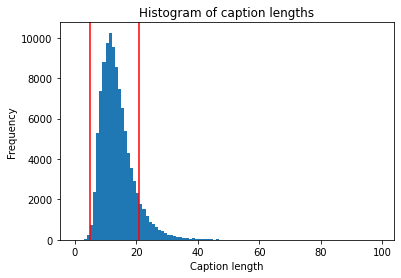

In [57]:
alltxt = ""
for (path, txt) in train_captions:
  for caption in txt:
    alltxt += " " + caption

# make a hisogram of the caption for all images
lengths = []
for (img_path, captions) in train_captions:
  for caption in captions:
    lengths.append(len(caption.split(" ")))

plt.hist(lengths, bins=range(0, 100, 1))
# plot a x = 10 line
plt.axvline(x=captionMAXLengthCap, color='r')
# and a 21 line
plt.axvline(x=captionMINLengthCap, color='r')
plt.title('Histogram of caption lengths')
plt.xlabel('Caption length')
plt.ylabel('Frequency')

In [58]:
# Remove the images with captions that are too long or too short

train_raw_capped = []
for (path, captions) in train_captions:
  flag = True
  for caption in captions:
    if len(caption.split()) > captionMAXLengthCap or len(caption.split()) < captionMINLengthCap:
      flag = False
  if flag:
    train_raw_capped.append((path, captions))

train_raw_capped = tf.data.experimental.from_list(train_raw_capped)

for (img, captions) in train_raw_capped.take(2):
  for i in captions:
    print(i)

tf.Tensor(b'The skier is wearing a yellow jumpsuit and sliding across a yellow rail .', shape=(), dtype=string)
tf.Tensor(b'A yellow uniformed skier is performing a trick across a railed object .', shape=(), dtype=string)
tf.Tensor(b'A skier in electric green on the edge of a ramp made of metal bars .', shape=(), dtype=string)
tf.Tensor(b'A person on skis on a rail at night .', shape=(), dtype=string)
tf.Tensor(b'A skier slides along a metal rail .', shape=(), dtype=string)
tf.Tensor(b'Two boys are in the foreground of a seashore scene with a boat in the background .', shape=(), dtype=string)
tf.Tensor(b'A couple of children playing in the shallow water with an upraised house nearby .', shape=(), dtype=string)
tf.Tensor(b'Two boys are playing in the water near an old building and a boat .', shape=(), dtype=string)
tf.Tensor(b'Two children play in the water by a pier and building .', shape=(), dtype=string)
tf.Tensor(b'Two children play in water in front of a building .', shape=(), dtyp

### Tokenizers

Κρατάμε το βασικό standardize αφού οποιαδήποτε άλλη επεξεργασία των λέξεων θα είχε ως αποτέλεσμα το μοντέλο να μην μπορεί να παράξει σωστά tokens-λέξεις για τα captions εξόδου.

In [59]:
vocabulary_size = 10000

tokenizer2 = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    ragged=True)

# ------------------------------------------------

vocabulary_size = 2000
tokenizer3 = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    ragged=True)

In [60]:
tokenizer2.adapt(train_raw_capped.map(lambda fp,txt: txt).unbatch().batch(1024))
tokenizer3.adapt(train_raw_capped.map(lambda fp,txt: txt).unbatch().batch(1024))

In [61]:
tokenizers = [tokenizer, tokenizer2, tokenizer3]

## Embedings

In [ ]:
# download the gensim embeddings glove-wiki
!pip install -U gensim
import gensim.downloader

# for 50, 100, 200, 300

glove50 = gensim.downloader.load('glove-wiki-gigaword-50')
glove100 = gensim.downloader.load('glove-wiki-gigaword-100')
glove200 = gensim.downloader.load('glove-wiki-gigaword-200')
glove300 = gensim.downloader.load('glove-wiki-gigaword-300')

In [ ]:
glove50.name = 'glove50'
glove100.name = 'glove100'
glove200.name = 'glove200'
glove300.name = 'glove300'

embeddings = [glove50, glove100, glove200, glove300]

#### Gensim Embeddings to Keras Embedding Layer

In [ ]:

def gensim_to_keras_embedding(tokenizer, model, train_embeddings=False):
    keyed_vectors = model  # structure holding the result of training
    weights = keyed_vectors.vectors  # vectors themselves, a 2D numpy array    
    index_to_key = keyed_vectors.index_to_key  # which row in `weights` corresponds to which word?
    key_to_index = keyed_vectors.key_to_index
    
    vocab = tokenizer.get_vocabulary()
    W = np.zeros((len(vocab), weights.shape[1]))
    found, not_found = 0, 0
    for i,w in enumerate(vocab):
      try:
          W[i] = model.get_vector(w)
          found+=1
      except:
          not_found+=1
    print(f'(Found, NotFound) = ({found}, {not_found}) when getting prebuilt embeddings')
    layer = tf.keras.layers.Embedding(
        input_dim=len(vocab),
        output_dim=weights.shape[1],
        weights=[W],
        trainable=train_embeddings,
    )
    print(layer.input_dim)
    return layer



# Run Loop

In [64]:
MAX_EPOCHS = 50 # default 100 
MAX_PATIENCE = 4 # default 5

BLEU_SCORE_EVALUATION_LENGTH = 100 # default 1k


In [ ]:
# Blue Score object to keep results from the run function below
bleuScore = BLEUScoreClass(test_data=(test_captions), model=model)

In [88]:
def run(tokenizers, encoders, embeddings, dropouts, num_layers):
  
  for encoder in encoders:
    for tokenizer in tokenizers:
      
      DATASET_UNIQUE_NAME = encoder.name + '_' + tokenizer.name # include emb, dec_parameters, yesNoBeamSearch
    
      # Use train_raw_capped which has a better window of 
      save_dataset(train_raw_capped, 'train_cache_'+DATASET_UNIQUE_NAME, encoder, tokenizer) # 2.4 min
      save_dataset(test_raw, 'test_cache_'+DATASET_UNIQUE_NAME, encoder, tokenizer) # 40 sec
       
      train_ds = load_dataset('./train_cache_' + DATASET_UNIQUE_NAME)
      test_ds = load_dataset('./test_cache_'+ DATASET_UNIQUE_NAME)

      
      units = 256
      #
      # This is Done Here in Order to fix the correspondance Word -> Vector Embedding that is incorrect
      # Beetween the correspondance Word -> Token -> Vector Embedding from the loaded model
      #
      embeddingsLayers = list(map(lambda model: gensim_to_keras_embedding(tokenizer, model) if model != None else None, embeddings))
      
      for embeddingsLayer in embeddingsLayers:  
        for dropout in dropouts:
          for num_layer in num_layers:
            if embeddingsLayer != None:
              units = embeddingsLayer.output_dim 

              # Build The Output Layer
            output_layer = TokenOutput(tokenizer, banned_tokens=('', '[UNK]', '[START]'))
            output_layer.adapt(train_ds.map(lambda inputs, labels: labels))


            modelEncoder = Captioner(tokenizer, feature_extractor=encoder, output_layer=output_layer,
                        units=units, dropout_rate=dropout, num_layers=num_layer, num_heads=2, embeddings=embeddingsLayer)
            callbacksEncoder = [
            GenerateText(),
            tf.keras.callbacks.EarlyStopping(
                patience=MAX_PATIENCE, restore_best_weights=True)]
            
            modelEncoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                    loss=masked_loss,
                    metrics=[masked_acc,], )
            #
            # fit for about 6 min for each encoder
            #
            historyEncoder = modelEncoder.fit(
              train_ds.repeat(),
              steps_per_epoch=100,
              validation_data=test_ds.repeat(),
              validation_steps=20,
              epochs=MAX_EPOCHS,
              callbacks=callbacksEncoder)
            

            #
            # Fix the name to include all the parameters
            # and ADD BEAM SEARCH EVALUATION OR INTERNALLY IN CALCULATE BLUE SCORE FOR 1K
            # 
            bleuScore.model = modelEncoder
            bleuScore.test_data = test_raw
            bleuScore.calculate_bleu_score_batched(test_raw, nameId=DATASET_UNIQUE_NAME+(embeddingsLayer.name if embeddingsLayer != None else 'Trainable')+'_'+str(dropout)+'_'+str(num_layer))
            print(bleuScore.logs)

      # DELETE THE CACHED STUFF FOR NEXT LOOP so colab doesn't fill
      !rm -rf {'train_cache_'+DATASET_UNIQUE_NAME}
      !rm -rf {'test_cache_'+DATASET_UNIQUE_NAME}
  return bleuScore 
        

In [178]:
!rm -rf test_cache_*
!rm -rf train_cache_*

In [71]:
embeddings.append(None) # None embeddings means trainnable
embeddings

 None]

In [81]:
blueScoreResults = run([tokenizers[0]], encoders[:2], embeddings[2:], dropouts=[0.3, 0.5], num_layers=[2,3,4])
print(blueScoreResults.logs)

456it [02:26,  3.10it/s]
142it [00:30,  4.71it/s]


(Found, NotFound) = (4933, 67) when getting prebuilt embeddings
5000
(Found, NotFound) = (4933, 67) when getting prebuilt embeddings
5000


100%|██████████| 2278/2278 [00:26<00:00, 84.60it/s] 



Uniform entropy: 8.52
Marginal entropy: 5.44
Epoch 1/50
 99/100 [============================>.] - ETA: 0s - loss: 5.1607 - masked_acc: 0.1912

a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a a man in a man in a man in a a man in a man
a man in a up a boy in a man wearing
music

100/100 [==============================] - 23s 110ms/step - loss: 5.1597 - masked_acc: 0.1915 - val_loss: 5.0115 - val_masked_acc: 0.2154
Epoch 2/50
 99/100 [============================>.] - ETA: 0s - loss: 4.8340 - masked_acc: 0.2396

a man in a a man in a a a a a a man in a a a a man in a a a a man in a a a a a a a a man in a man in a a a a a a a man in
a man in a man in a a
a women dog is in the blue during

100/100 [==============================] - 10s 98ms/step - loss: 4.8353 - masked_acc: 0.2394 - val_loss: 4.7430 - val_masked_acc: 0.2493
Epoch 3/50
 99/100 [============================>.] - ETA: 0s - loss: 4.6613 - masked_acc: 0.2585

a man in a a a

32it [01:58,  3.69s/it]


Count is 1024
{'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_2': 0.20050462717546416}


100%|██████████| 2278/2278 [00:10<00:00, 217.21it/s]



Uniform entropy: 8.52
Marginal entropy: 5.44
Epoch 1/50
100/100 [==============================] - ETA: 0s - loss: 5.1797 - masked_acc: 0.1939

a man in a man in a man in a man in a man in a a man in a man in a man in a a man in a man in a man in a man in a a man in a a man in a a man
a man in a man in a man on a in a man
dress in a beside on the a watching

100/100 [==============================] - 29s 127ms/step - loss: 5.1797 - masked_acc: 0.1939 - val_loss: 5.0399 - val_masked_acc: 0.2239
Epoch 2/50
 99/100 [============================>.] - ETA: 0s - loss: 4.8217 - masked_acc: 0.2436

a man in a man in a man in a a
a man in a black man in a a
a head trees

100/100 [==============================] - 7s 69ms/step - loss: 4.8219 - masked_acc: 0.2436 - val_loss: 4.7527 - val_masked_acc: 0.2490
Epoch 3/50
 99/100 [============================>.] - ETA: 0s - loss: 4.6758 - masked_acc: 0.2560

a man in a red and a red
a man in the on the concrete
a is 2 through the small dressed to pul

32it [02:52,  5.39s/it]


Count is 1024
{'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_2': 0.20050462717546416, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_3': 0.1884908078954575}


100%|██████████| 2278/2278 [00:09<00:00, 249.38it/s]



Uniform entropy: 8.52
Marginal entropy: 5.44
Epoch 1/50
100/100 [==============================] - ETA: 0s - loss: 5.2072 - masked_acc: 0.1836

a man in a man in a man in a man in a man in a man in a man in a man in a man
a man in a man a a woman in a man are a woman on a man
blue men on the dock sleds

100/100 [==============================] - 32s 131ms/step - loss: 5.2072 - masked_acc: 0.1836 - val_loss: 5.0286 - val_masked_acc: 0.2173
Epoch 2/50
100/100 [==============================] - ETA: 0s - loss: 4.8398 - masked_acc: 0.2414

a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a
a man in a woman in a man in the in the
with a a small little in flower

100/100 [==============================] - 13s 134ms/step - loss: 4.8398 - masked_acc: 0.2414 - val_loss: 4.7983 - val_masked_acc: 0.2406
Epoch 3/50
 99/100 [============================>.] - ETA: 0s - loss: 4.6854 - masked_acc: 0.2541

a

32it [03:23,  6.35s/it]


Count is 1024
{'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_2': 0.20050462717546416, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_3': 0.1884908078954575, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_4': 0.211807483358104}


100%|██████████| 2278/2278 [00:09<00:00, 243.34it/s]



Uniform entropy: 8.52
Marginal entropy: 5.44
Epoch 1/50
100/100 [==============================] - ETA: 0s - loss: 5.2318 - masked_acc: 0.1812

a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in the
a man and a man
a watch sitting girl in his a a man walking with a woman

100/100 [==============================] - 21s 104ms/step - loss: 5.2318 - masked_acc: 0.1812 - val_loss: 5.0725 - val_masked_acc: 0.2117
Epoch 2/50
100/100 [==============================] - ETA: 0s - loss: 4.9329 - masked_acc: 0.2299

a man in a man in a man in a man in a man in a man in a man in a man in a man
a man is in a woman in a dog is is a man
sitting walking playing

100/100 [==============================] - 7s 75ms/step - loss: 4.9329 - masked_acc: 0.2299 - val_loss: 4.8292 - val_masked_acc: 0.2287
Epoch 3/50
 99/100 [============================>.] - ETA: 0s - loss: 4.7835 - masked_acc: 0.2428

a man in a man in

32it [02:01,  3.81s/it]


Count is 1024
{'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_2': 0.20050462717546416, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_3': 0.1884908078954575, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_4': 0.211807483358104, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_2': 0.19286757123107257}


100%|██████████| 2278/2278 [00:08<00:00, 256.95it/s]



Uniform entropy: 8.52
Marginal entropy: 5.44
Epoch 1/50
 99/100 [============================>.] - ETA: 0s - loss: 5.2495 - masked_acc: 0.1779

a man
a on a man and the a man
a away out the her black setting a very woman with a man running sunrise house dog

100/100 [==============================] - 25s 88ms/step - loss: 5.2482 - masked_acc: 0.1780 - val_loss: 5.1202 - val_masked_acc: 0.2030
Epoch 2/50
100/100 [==============================] - ETA: 0s - loss: 4.9100 - masked_acc: 0.2264

a man in a man in a man
a man
his construction through a customers

100/100 [==============================] - 6s 63ms/step - loss: 4.9100 - masked_acc: 0.2264 - val_loss: 4.8250 - val_masked_acc: 0.2301
Epoch 3/50
 99/100 [============================>.] - ETA: 0s - loss: 4.7585 - masked_acc: 0.2459

a man in a white and a white dog
a young girl in the
a yellow woman lays hair with white lawn is the bicycle library

100/100 [==============================] - 7s 70ms/step - loss: 4.7566 - masked_acc

32it [03:36,  6.75s/it]


Count is 1024
{'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_2': 0.20050462717546416, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_3': 0.1884908078954575, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_4': 0.211807483358104, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_2': 0.19286757123107257, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_3': 0.1504544295955735}


100%|██████████| 2278/2278 [00:09<00:00, 243.58it/s]



Uniform entropy: 8.52
Marginal entropy: 5.44
Epoch 1/50
100/100 [==============================] - ETA: 0s - loss: 5.3349 - masked_acc: 0.1576

a man
two woman is man
a walks

100/100 [==============================] - 27s 86ms/step - loss: 5.3349 - masked_acc: 0.1576 - val_loss: 5.1665 - val_masked_acc: 0.1960
Epoch 2/50
 99/100 [============================>.] - ETA: 0s - loss: 5.0181 - masked_acc: 0.2167

a man in a man in a man
a black boy is
small leaves outside

100/100 [==============================] - 7s 70ms/step - loss: 5.0158 - masked_acc: 0.2170 - val_loss: 4.9460 - val_masked_acc: 0.2151
Epoch 3/50
100/100 [==============================] - ETA: 0s - loss: 4.8451 - masked_acc: 0.2333

a man in a man in a man in a man in a man in a man
a man in a water
a older man carrying a man on the windows and high

100/100 [==============================] - 10s 96ms/step - loss: 4.8451 - masked_acc: 0.2333 - val_loss: 4.8121 - val_masked_acc: 0.2403
Epoch 4/50
 99/100 [==============

32it [02:15,  4.25s/it]


Count is 1024
{'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_2': 0.20050462717546416, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_3': 0.1884908078954575, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_4': 0.211807483358104, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_2': 0.19286757123107257, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_3': 0.1504544295955735, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_4': 0.19868961434492532}


100%|██████████| 2278/2278 [00:09<00:00, 246.77it/s]



Uniform entropy: 8.52
Marginal entropy: 5.44
Epoch 1/50
100/100 [==============================] - ETA: 0s - loss: 5.0325 - masked_acc: 0.2116

a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a
a man with a building
a a game down a air

100/100 [==============================] - 20s 102ms/step - loss: 5.0325 - masked_acc: 0.2116 - val_loss: 4.7832 - val_masked_acc: 0.2343
Epoch 2/50
 99/100 [============================>.] - ETA: 0s - loss: 4.6556 - masked_acc: 0.2593

a man in a a a blue shirt is in a blue shirt is in a blue shirt is in a blue shirt is in a blue shirt is in a red shirt is in a blue shirt is in a blue shirt is in the water
a boy is in the a of a red dog is in a and a field
a man dressed is the down the snow looks young orange rests a a city from bicycle in jumps individuals in a khaki has slide uphill of the mustache

100/100 [==============================] - 10s 101ms/ste

32it [01:16,  2.38s/it]


Count is 1024
{'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_2': 0.20050462717546416, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_3': 0.1884908078954575, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_4': 0.211807483358104, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_2': 0.19286757123107257, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_3': 0.1504544295955735, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_4': 0.19868961434492532, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.3_2': 0.19900081172485448}


100%|██████████| 2278/2278 [00:09<00:00, 248.96it/s]



Uniform entropy: 8.52
Marginal entropy: 5.44
Epoch 1/50
 99/100 [============================>.] - ETA: 0s - loss: 5.0446 - masked_acc: 0.2124

a man in a man in a a a a a man
a man
the white jeans and man in jar

100/100 [==============================] - 25s 89ms/step - loss: 5.0431 - masked_acc: 0.2128 - val_loss: 4.8460 - val_masked_acc: 0.2439
Epoch 2/50
 99/100 [============================>.] - ETA: 0s - loss: 4.6588 - masked_acc: 0.2642

a man in a blue shirt is in a blue shirt is in a blue shirt is in a blue shirt is in a blue shirt is in a blue shirt
a man is a red shirt is is in a red dog
a little boy with past a sitting with a boat down a denim in bike

100/100 [==============================] - 10s 101ms/step - loss: 4.6574 - masked_acc: 0.2642 - val_loss: 4.6206 - val_masked_acc: 0.2544
Epoch 3/50
 99/100 [============================>.] - ETA: 0s - loss: 4.4932 - masked_acc: 0.2745

a boy in a blue shirt is in a red shirt is in a red shirt is in the water
a man is runni

32it [01:58,  3.72s/it]


Count is 1024
{'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_2': 0.20050462717546416, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_3': 0.1884908078954575, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_4': 0.211807483358104, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_2': 0.19286757123107257, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_3': 0.1504544295955735, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_4': 0.19868961434492532, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.3_2': 0.19900081172485448, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.3_3': 0.18883102152705158}


100%|██████████| 2278/2278 [00:09<00:00, 243.22it/s]



Uniform entropy: 8.52
Marginal entropy: 5.44
Epoch 1/50
100/100 [==============================] - ETA: 0s - loss: 5.0957 - masked_acc: 0.2033

a man in a man in a man in a man in a man in a
a man in a group
truck of a at the looking and a speaking jumping

100/100 [==============================] - 30s 114ms/step - loss: 5.0957 - masked_acc: 0.2033 - val_loss: 4.8484 - val_masked_acc: 0.2325
Epoch 2/50
 99/100 [============================>.] - ETA: 0s - loss: 4.7164 - masked_acc: 0.2560

a man in a black and a black and a black and a black and a black and a black and a black and a black and a black and a black and a black and a black and a black and a black and a black and a
a dog is with a red is is in a on a for the water
a young chair air people and and in front

100/100 [==============================] - 14s 141ms/step - loss: 4.7138 - masked_acc: 0.2564 - val_loss: 4.6200 - val_masked_acc: 0.2532
Epoch 3/50
100/100 [==============================] - ETA: 0s - loss: 4.5490 - mas

32it [03:23,  6.35s/it]


Count is 1024
{'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_2': 0.20050462717546416, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_3': 0.1884908078954575, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_4': 0.211807483358104, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_2': 0.19286757123107257, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_3': 0.1504544295955735, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_4': 0.19868961434492532, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.3_2': 0.19900081172485448, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.3_3': 0.18883102152705158, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.3_4': 0.17486688456830213}


100%|██████████| 2278/2278 [00:08<00:00, 262.40it/s]



Uniform entropy: 8.52
Marginal entropy: 5.44
Epoch 1/50
100/100 [==============================] - ETA: 0s - loss: 5.1478 - masked_acc: 0.1933

a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a
a man in a man in a man in a and a the a young wearing a young boy in a man in a the the a is is
a brown dog deep with a of bike

100/100 [==============================] - 22s 117ms/step - loss: 5.1478 - masked_acc: 0.1933 - val_loss: 4.8461 - val_masked_acc: 0.2410
Epoch 2/50
 99/100 [============================>.] - ETA: 0s - loss: 4.7595 - masked_acc: 0.2507

a man in a man in a man in a man in a red is is is is is is is in a man in a man in a man in a red shirt is is is is in a man in a red shirt is is is is
a girl in a green jeans are playing the water
a boy coffee in these plays red blue is eating sliding a products shirt shirt at the there the golf wooden

100/100 [==========================

32it [01:53,  3.56s/it]


Count is 1024
{'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_2': 0.20050462717546416, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_3': 0.1884908078954575, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_4': 0.211807483358104, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_2': 0.19286757123107257, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_3': 0.1504544295955735, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_4': 0.19868961434492532, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.3_2': 0.19900081172485448, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.3_3': 0.18883102152705158, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.3_4': 0.17486688456830213, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.5_2': 0.18492387558064127}


100%|██████████| 2278/2278 [00:09<00:00, 245.59it/s]



Uniform entropy: 8.52
Marginal entropy: 5.44
Epoch 1/50
 99/100 [============================>.] - ETA: 0s - loss: 5.1670 - masked_acc: 0.1935

a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a
a man in a and a man in a the the street
the swimming

100/100 [==============================] - 29s 128ms/step - loss: 5.1638 - masked_acc: 0.1940 - val_loss: 4.9424 - val_masked_acc: 0.2259
Epoch 2/50
 99/100 [============================>.] - ETA: 0s - loss: 4.7759 - masked_acc: 0.2429

a man in a blue dog in the water
a woman in a large a in the girl is in a water
the person shirt a are over a the railing a while off diners

100/100 [==============================] - 8s 84ms/step - loss: 4.7768 - masked_acc: 0.2430 - val_loss: 4.6836 - val_masked_acc: 0.2602
Epoch 3/50
100/100 [==============================] - ETA: 0s - loss: 4.6070 - masked_acc: 0.2626

a man is in a blue
a young young woman o

32it [01:34,  2.94s/it]


Count is 1024
{'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_2': 0.20050462717546416, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_3': 0.1884908078954575, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_4': 0.211807483358104, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_2': 0.19286757123107257, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_3': 0.1504544295955735, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_4': 0.19868961434492532, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.3_2': 0.19900081172485448, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.3_3': 0.18883102152705158, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.3_4': 0.17486688456830213, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.5_2': 0.18492387558064127, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.5_3': 0.21536806848575268}


100%|██████████| 2278/2278 [00:09<00:00, 241.91it/s]



Uniform entropy: 8.52
Marginal entropy: 5.44
Epoch 1/50
100/100 [==============================] - ETA: 0s - loss: 5.2191 - masked_acc: 0.1828

a man in a man in a man
a man in a black girl and young man
people corn

100/100 [==============================] - 29s 99ms/step - loss: 5.2191 - masked_acc: 0.1828 - val_loss: 4.9885 - val_masked_acc: 0.2329
Epoch 2/50
100/100 [==============================] - ETA: 0s - loss: 4.8237 - masked_acc: 0.2391

a man in a black dog is in the water
a little man in the is is on a grass
a dirt blondhaired and a white brick crowd in two produce grass

100/100 [==============================] - 9s 91ms/step - loss: 4.8237 - masked_acc: 0.2391 - val_loss: 4.7624 - val_masked_acc: 0.2440
Epoch 3/50
100/100 [==============================] - ETA: 0s - loss: 4.6194 - masked_acc: 0.2568

a man in a water
a man in a black dog is is in a beach
a group of costume is jumping on a gondola

100/100 [==============================] - 9s 86ms/step - loss: 4.6194 - 

32it [02:27,  4.62s/it]


Count is 1024
{'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_2': 0.20050462717546416, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_3': 0.1884908078954575, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_4': 0.211807483358104, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_2': 0.19286757123107257, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_3': 0.1504544295955735, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_4': 0.19868961434492532, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.3_2': 0.19900081172485448, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.3_3': 0.18883102152705158, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.3_4': 0.17486688456830213, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.5_2': 0.18492387558064127, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.5_3': 0.21536806848575268, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.5_4': 0.1827730067809413}


100%|██████████| 2278/2278 [00:09<00:00, 252.34it/s]



Uniform entropy: 8.52
Marginal entropy: 5.44
Epoch 1/50
 99/100 [============================>.] - ETA: 0s - loss: 5.0997 - masked_acc: 0.2045

a man in a man
a man with a man in a young big
a at a walk in fire suspended is tube beanie by a instruments

100/100 [==============================] - 26s 142ms/step - loss: 5.0962 - masked_acc: 0.2048 - val_loss: 4.8688 - val_masked_acc: 0.2332
Epoch 2/50
100/100 [==============================] - ETA: 0s - loss: 4.7051 - masked_acc: 0.2536

a man in a man in a black dog is
a young man is in a man is a person
a man in the and a hand with a have a rock

100/100 [==============================] - 8s 76ms/step - loss: 4.7051 - masked_acc: 0.2536 - val_loss: 4.7144 - val_masked_acc: 0.2454
Epoch 3/50
100/100 [==============================] - ETA: 0s - loss: 4.4939 - masked_acc: 0.2748

a man in a blue shirt is in a water
a dog is standing a swimming in the water
a woman with the beach in his blows coat

100/100 [==============================]

32it [01:19,  2.50s/it]


Count is 1024
{'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_2': 0.20050462717546416, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_3': 0.1884908078954575, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_4': 0.211807483358104, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_2': 0.19286757123107257, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_3': 0.1504544295955735, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_4': 0.19868961434492532, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.3_2': 0.19900081172485448, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.3_3': 0.18883102152705158, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.3_4': 0.17486688456830213, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.5_2': 0.18492387558064127, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.5_3': 0.21536806848575268, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.5_4': 0.1827730067809413, 'BLEU_score-1k-vgg

100%|██████████| 2278/2278 [00:09<00:00, 242.17it/s]



Uniform entropy: 8.52
Marginal entropy: 5.44
Epoch 1/50
100/100 [==============================] - ETA: 0s - loss: 5.1031 - masked_acc: 0.2021

a man in a man in a man
a man and a brown wearing the down
white woman cellphone a with a holding a in the sweatshirt stand birthday

100/100 [==============================] - 29s 137ms/step - loss: 5.1031 - masked_acc: 0.2021 - val_loss: 4.8689 - val_masked_acc: 0.2221
Epoch 2/50
100/100 [==============================] - ETA: 0s - loss: 4.7103 - masked_acc: 0.2527

a man in a white is is is is in a white is is is in a white
a woman is in a white is field to the building
a child outside jumping in a girls

100/100 [==============================] - 9s 90ms/step - loss: 4.7103 - masked_acc: 0.2527 - val_loss: 4.6624 - val_masked_acc: 0.2478
Epoch 3/50
100/100 [==============================] - ETA: 0s - loss: 4.5314 - masked_acc: 0.2699

a man in a white is is is is is is in a white
a man is in a blue shirt is is is are on a table
a group of 

32it [01:32,  2.88s/it]


Count is 1024
{'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_2': 0.20050462717546416, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_3': 0.1884908078954575, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_4': 0.211807483358104, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_2': 0.19286757123107257, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_3': 0.1504544295955735, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_4': 0.19868961434492532, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.3_2': 0.19900081172485448, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.3_3': 0.18883102152705158, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.3_4': 0.17486688456830213, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.5_2': 0.18492387558064127, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.5_3': 0.21536806848575268, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.5_4': 0.1827730067809413, 'BLEU_score-1k-vgg

100%|██████████| 2278/2278 [00:09<00:00, 247.08it/s]



Uniform entropy: 8.52
Marginal entropy: 5.44
Epoch 1/50
100/100 [==============================] - ETA: 0s - loss: 5.1174 - masked_acc: 0.1991

a man in a man in a man
a boy dog in a
white in the yellow covered

100/100 [==============================] - 33s 137ms/step - loss: 5.1174 - masked_acc: 0.1991 - val_loss: 4.9862 - val_masked_acc: 0.2123
Epoch 2/50
100/100 [==============================] - ETA: 0s - loss: 4.7513 - masked_acc: 0.2473

a man in a man in a water
a woman is is a young a white a with a
two playing skateboard of for a smiling

100/100 [==============================] - 9s 91ms/step - loss: 4.7513 - masked_acc: 0.2473 - val_loss: 4.7103 - val_masked_acc: 0.2498
Epoch 3/50
100/100 [==============================] - ETA: 0s - loss: 4.5569 - masked_acc: 0.2643

a man in a water
a man in a white in the a a a blue is playing a water
a man in the

100/100 [==============================] - 9s 92ms/step - loss: 4.5569 - masked_acc: 0.2643 - val_loss: 4.4445 - val_masked_

32it [01:39,  3.10s/it]


Count is 1024
{'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_2': 0.20050462717546416, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_3': 0.1884908078954575, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_4': 0.211807483358104, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_2': 0.19286757123107257, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_3': 0.1504544295955735, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_4': 0.19868961434492532, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.3_2': 0.19900081172485448, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.3_3': 0.18883102152705158, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.3_4': 0.17486688456830213, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.5_2': 0.18492387558064127, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.5_3': 0.21536806848575268, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.5_4': 0.1827730067809413, 'BLEU_score-1k-vgg

100%|██████████| 2278/2278 [00:09<00:00, 245.80it/s]



Uniform entropy: 8.52
Marginal entropy: 5.44
Epoch 1/50
 99/100 [============================>.] - ETA: 0s - loss: 5.1904 - masked_acc: 0.1918

a man in a in a in a a
a man in a in the in the front
an woman person room in the up while set

100/100 [==============================] - 24s 118ms/step - loss: 5.1901 - masked_acc: 0.1920 - val_loss: 4.9421 - val_masked_acc: 0.2237
Epoch 2/50
100/100 [==============================] - ETA: 0s - loss: 4.7913 - masked_acc: 0.2486

a man in a blue in a
a man in a blue on the is in the ocean
on a man in the jeans jacket is jacket himself of the large cigarette in red person who are wearing a two older kitchen

100/100 [==============================] - 8s 81ms/step - loss: 4.7913 - masked_acc: 0.2486 - val_loss: 4.7433 - val_masked_acc: 0.2474
Epoch 3/50
 99/100 [============================>.] - ETA: 0s - loss: 4.5947 - masked_acc: 0.2667

a man in a blue shirt is is is in a the water
a man in a white shirt wearing a white is playing a white ch

32it [01:16,  2.38s/it]


Count is 1024
{'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_2': 0.20050462717546416, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_3': 0.1884908078954575, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_4': 0.211807483358104, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_2': 0.19286757123107257, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_3': 0.1504544295955735, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_4': 0.19868961434492532, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.3_2': 0.19900081172485448, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.3_3': 0.18883102152705158, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.3_4': 0.17486688456830213, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.5_2': 0.18492387558064127, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.5_3': 0.21536806848575268, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.5_4': 0.1827730067809413, 'BLEU_score-1k-vgg

100%|██████████| 2278/2278 [00:08<00:00, 258.71it/s]



Uniform entropy: 8.52
Marginal entropy: 5.44
Epoch 1/50
100/100 [==============================] - ETA: 0s - loss: 5.1973 - masked_acc: 0.1880

a man in a man
a man in a field
an white ninja of the over sky men ball

100/100 [==============================] - 28s 130ms/step - loss: 5.1973 - masked_acc: 0.1880 - val_loss: 5.0584 - val_masked_acc: 0.2140
Epoch 2/50
 99/100 [============================>.] - ETA: 0s - loss: 4.8386 - masked_acc: 0.2427

a man in a dog in the boy
a boy in a black swimming are is in the black boy
a subway carrying a wearing a she poodles on the green crown

100/100 [==============================] - 9s 90ms/step - loss: 4.8358 - masked_acc: 0.2430 - val_loss: 4.7362 - val_masked_acc: 0.2478
Epoch 3/50
 99/100 [============================>.] - ETA: 0s - loss: 4.6778 - masked_acc: 0.2531

a man in a water
a young dog is on a white dog in the girl in a water
a dog bystanders karaoke on a tree in a sandy looking cityscape

100/100 [============================

32it [01:42,  3.21s/it]


Count is 1024
{'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_2': 0.20050462717546416, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_3': 0.1884908078954575, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_4': 0.211807483358104, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_2': 0.19286757123107257, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_3': 0.1504544295955735, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_4': 0.19868961434492532, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.3_2': 0.19900081172485448, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.3_3': 0.18883102152705158, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.3_4': 0.17486688456830213, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.5_2': 0.18492387558064127, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.5_3': 0.21536806848575268, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.5_4': 0.1827730067809413, 'BLEU_score-1k-vgg

100%|██████████| 2278/2278 [00:08<00:00, 254.55it/s]



Uniform entropy: 8.52
Marginal entropy: 5.44
Epoch 1/50
 99/100 [============================>.] - ETA: 0s - loss: 5.2780 - masked_acc: 0.1703

a man in a in a in a in a in a in a in a in a in a in a
a man man in a with a people is
a boy toy is flowers pink night

100/100 [==============================] - 37s 174ms/step - loss: 5.2747 - masked_acc: 0.1712 - val_loss: 5.0595 - val_masked_acc: 0.2099
Epoch 2/50
100/100 [==============================] - ETA: 0s - loss: 4.8714 - masked_acc: 0.2363

a man in a a a black is in a black
a man in a black with a dog of a is
a wearing purple intently going walking in a smiles is drummer

100/100 [==============================] - 10s 104ms/step - loss: 4.8714 - masked_acc: 0.2363 - val_loss: 4.8786 - val_masked_acc: 0.2244
Epoch 3/50
100/100 [==============================] - ETA: 0s - loss: 4.6828 - masked_acc: 0.2497

a man in a water
a man in a water on the black a picture
a ball playing a water working

100/100 [===========================

32it [01:35,  2.99s/it]


Count is 1024
{'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_2': 0.20050462717546416, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_3': 0.1884908078954575, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_4': 0.211807483358104, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_2': 0.19286757123107257, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_3': 0.1504544295955735, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_4': 0.19868961434492532, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.3_2': 0.19900081172485448, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.3_3': 0.18883102152705158, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.3_4': 0.17486688456830213, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.5_2': 0.18492387558064127, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.5_3': 0.21536806848575268, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.5_4': 0.1827730067809413, 'BLEU_score-1k-vgg

456it [01:50,  4.11it/s]
142it [00:34,  4.16it/s]


(Found, NotFound) = (4933, 67) when getting prebuilt embeddings
5000
(Found, NotFound) = (4933, 67) when getting prebuilt embeddings
5000


100%|██████████| 2278/2278 [00:28<00:00, 81.04it/s]



Uniform entropy: 8.52
Marginal entropy: 5.44
Epoch 1/50
100/100 [==============================] - ETA: 0s - loss: 5.1816 - masked_acc: 0.1921

a man in a man in a man
a young is water
female water

100/100 [==============================] - 18s 68ms/step - loss: 5.1816 - masked_acc: 0.1921 - val_loss: 5.0369 - val_masked_acc: 0.2262
Epoch 2/50
100/100 [==============================] - ETA: 0s - loss: 4.8706 - masked_acc: 0.2411

a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a
a man is his a man in a man in a small white dog in a man in a camera
a men in a running a in a looks shopping in trying

100/100 [==============================] - 9s 92ms/step - loss: 4.8706 - masked_acc: 0.2411 - val_loss: 4.7614 - val_masked_acc: 0.2453
Epoch 3/50
100/100 [==============================] - ETA: 0s - loss: 4.6801 - masked_acc: 0.2573

a man in a man in a blue and a man in a blue and a man in a b

32it [01:57,  3.67s/it]


Count is 1024
{'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_2': 0.20050462717546416, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_3': 0.1884908078954575, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_4': 0.211807483358104, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_2': 0.19286757123107257, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_3': 0.1504544295955735, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_4': 0.19868961434492532, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.3_2': 0.19900081172485448, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.3_3': 0.18883102152705158, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.3_4': 0.17486688456830213, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.5_2': 0.18492387558064127, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.5_3': 0.21536806848575268, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.5_4': 0.1827730067809413, 'BLEU_score-1k-vgg

100%|██████████| 2278/2278 [00:13<00:00, 168.20it/s]



Uniform entropy: 8.52
Marginal entropy: 5.44
Epoch 1/50
 99/100 [============================>.] - ETA: 0s - loss: 5.1910 - masked_acc: 0.1902

a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a
a man is on a
men peak for an offering of gas very

100/100 [==============================] - 26s 117ms/step - loss: 5.1890 - masked_acc: 0.1906 - val_loss: 4.9916 - val_masked_acc: 0.2190
Epoch 2/50
100/100 [==============================] - ETA: 0s - loss: 4.8040 - masked_acc: 0.2447

a man in a man in a man in a man in a a a man in a
a man in a man in a girls in the a man in a group of a large
a water breaks cloth of white is people green flowers

100/100 [==============================] - 9s 86ms/step - loss: 4.8040 - masked_acc: 0.2447 - val_loss: 4.7645 - val_masked_acc: 0.2475
Epoch 3/50
 99/100 [============================>.] - ETA: 0s - loss: 4.6518 - masked_acc: 0.2592

a man is in a blac

32it [02:05,  3.92s/it]


Count is 1024
{'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_2': 0.20050462717546416, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_3': 0.1884908078954575, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_4': 0.211807483358104, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_2': 0.19286757123107257, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_3': 0.1504544295955735, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_4': 0.19868961434492532, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.3_2': 0.19900081172485448, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.3_3': 0.18883102152705158, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.3_4': 0.17486688456830213, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.5_2': 0.18492387558064127, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.5_3': 0.21536806848575268, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.5_4': 0.1827730067809413, 'BLEU_score-1k-vgg

100%|██████████| 2278/2278 [00:11<00:00, 192.02it/s]



Uniform entropy: 8.52
Marginal entropy: 5.44
Epoch 1/50
100/100 [==============================] - ETA: 0s - loss: 5.1991 - masked_acc: 0.1821

a man in a man in a man in a man in a man in a man in a man
a man in a man in a in a woman in a man in a man with a man in a is water
winter bread on a small man and plays as black on in leaves in

100/100 [==============================] - 32s 132ms/step - loss: 5.1991 - masked_acc: 0.1821 - val_loss: 5.0368 - val_masked_acc: 0.2203
Epoch 2/50
 99/100 [============================>.] - ETA: 0s - loss: 4.8533 - masked_acc: 0.2423

a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a
a man is a young man is
a black red instructor a dog

100/100 [==============================] - 12s 118ms/step - loss: 4.8528 - masked_acc: 0.2420 - val_loss: 4.8360 - val_masked_acc: 0.2315
Epoch 3/50
 99/100 [============================>.] - ETA: 0s - loss: 4.6819 - mas

32it [03:16,  6.15s/it]


Count is 1024
{'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_2': 0.20050462717546416, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_3': 0.1884908078954575, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_4': 0.211807483358104, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_2': 0.19286757123107257, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_3': 0.1504544295955735, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_4': 0.19868961434492532, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.3_2': 0.19900081172485448, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.3_3': 0.18883102152705158, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.3_4': 0.17486688456830213, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.5_2': 0.18492387558064127, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.5_3': 0.21536806848575268, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.5_4': 0.1827730067809413, 'BLEU_score-1k-vgg

100%|██████████| 2278/2278 [00:08<00:00, 266.17it/s]



Uniform entropy: 8.52
Marginal entropy: 5.44
Epoch 1/50
 99/100 [============================>.] - ETA: 0s - loss: 5.2485 - masked_acc: 0.1784

a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a
a man
a

100/100 [==============================] - 20s 87ms/step - loss: 5.2478 - masked_acc: 0.1787 - val_loss: 5.0116 - val_masked_acc: 0.2197
Epoch 2/50
 99/100 [============================>.] - ETA: 0s - loss: 4.9306 - masked_acc: 0.2336

a man is in a man is in a man is
a man is the a
a young runs of a swimming boys is

100/100 [==============================] - 5s 51ms/step - loss: 4.9300 - masked_acc: 0.2337 - val_loss: 4.8307 - val_masked_acc: 0.2367
Epoch 3/50
 99/100 [============================>.] - ETA: 0s - loss: 4.7673 - masked_acc: 0.2415

a man in a man in a man in a a a man in a a man in a a a man in a man in a a a man in a man in a a a a a a man in a a man in a a man
a man in a m

32it [02:55,  5.48s/it]


Count is 1024
{'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_2': 0.20050462717546416, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_3': 0.1884908078954575, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_4': 0.211807483358104, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_2': 0.19286757123107257, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_3': 0.1504544295955735, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_4': 0.19868961434492532, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.3_2': 0.19900081172485448, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.3_3': 0.18883102152705158, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.3_4': 0.17486688456830213, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.5_2': 0.18492387558064127, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.5_3': 0.21536806848575268, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.5_4': 0.1827730067809413, 'BLEU_score-1k-vgg

100%|██████████| 2278/2278 [00:08<00:00, 260.86it/s]



Uniform entropy: 8.52
Marginal entropy: 5.44
Epoch 1/50
100/100 [==============================] - ETA: 0s - loss: 5.2308 - masked_acc: 0.1804

a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a
a man a dog with a in a on a girl in a man in a the
a and in a brown graffiti and the and jacket

100/100 [==============================] - 26s 125ms/step - loss: 5.2308 - masked_acc: 0.1804 - val_loss: 5.1022 - val_masked_acc: 0.2118
Epoch 2/50
100/100 [==============================] - ETA: 0s - loss: 4.9275 - masked_acc: 0.2323

a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in the
a girl is in a man is is are on a man in the of the working
a rubble with water

100/100 [==============================] - 9s 90ms/step - loss: 4.9275 - masked_acc: 0.2323 - val_loss: 4.8895 - val_masked_acc: 0.2290
Epoch 3/50
 99/100 [============================>.] - ETA: 0s -

32it [02:14,  4.21s/it]


Count is 1024
{'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_2': 0.20050462717546416, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_3': 0.1884908078954575, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_4': 0.211807483358104, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_2': 0.19286757123107257, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_3': 0.1504544295955735, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_4': 0.19868961434492532, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.3_2': 0.19900081172485448, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.3_3': 0.18883102152705158, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.3_4': 0.17486688456830213, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.5_2': 0.18492387558064127, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.5_3': 0.21536806848575268, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.5_4': 0.1827730067809413, 'BLEU_score-1k-vgg

100%|██████████| 2278/2278 [00:10<00:00, 222.34it/s]


Uniform entropy: 8.52
Marginal entropy: 5.44
Epoch 1/50


 99/100 [============================>.] - ETA: 0s - loss: 5.2933 - masked_acc: 0.1688

a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a
a is the man in the in a with a man in a her
the woman being the with other in a doing teammate walk

100/100 [==============================] - 32s 148ms/step - loss: 5.2918 - masked_acc: 0.1691 - val_loss: 5.1174 - val_masked_acc: 0.2061
Epoch 2/50
 99/100 [============================>.] - ETA: 0s - loss: 4.9735 - masked_acc: 0.2288

a man in a man in a man in a man in a man
a man in a man in a of a man
a is sits in his carpet

100/100 [==============================] - 8s 81ms/step - loss: 4.9705 - masked_acc: 0.2290 - val_loss: 4.8849 - val_masked_acc: 0.2307
Epoch 3/50
 99/100 [============================>.] - ETA: 0s - loss: 4.8074 - masked_acc: 0.2425

a man in a man in a dog in a dog
a man with a woman is in a stage
the men wearing the sit down t

32it [01:58,  3.70s/it]


Count is 1024
{'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_2': 0.20050462717546416, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_3': 0.1884908078954575, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_4': 0.211807483358104, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_2': 0.19286757123107257, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_3': 0.1504544295955735, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_4': 0.19868961434492532, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.3_2': 0.19900081172485448, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.3_3': 0.18883102152705158, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.3_4': 0.17486688456830213, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.5_2': 0.18492387558064127, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.5_3': 0.21536806848575268, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.5_4': 0.1827730067809413, 'BLEU_score-1k-vgg

100%|██████████| 2278/2278 [00:08<00:00, 264.90it/s]



Uniform entropy: 8.52
Marginal entropy: 5.44
Epoch 1/50
100/100 [==============================] - ETA: 0s - loss: 5.0786 - masked_acc: 0.2063

a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a
a man in a group his
a man man is in a group outside a trunks covers large car pumps wearing while a the are and people in construction

100/100 [==============================] - 19s 87ms/step - loss: 5.0786 - masked_acc: 0.2063 - val_loss: 4.9061 - val_masked_acc: 0.2285
Epoch 2/50
 99/100 [============================>.] - ETA: 0s - loss: 4.6793 - masked_acc: 0.2564

a man in a a black dog is in a black dog is in a white shirt is
a man is playing a dog is in a black dog
an woman in cooks and several rocks

100/100 [==============================] - 6s 63ms/step - loss: 4.6762 - masked_acc: 0.2568 - val_loss: 4.6111 - val_masked_acc: 0.2641
Epoch 3/50
 99/100 [============================>.] - ETA: 0s - loss: 4.4917 - masked_acc: 0.2741

a man in a bl

32it [01:23,  2.61s/it]


Count is 1024
{'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_2': 0.20050462717546416, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_3': 0.1884908078954575, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_4': 0.211807483358104, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_2': 0.19286757123107257, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_3': 0.1504544295955735, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_4': 0.19868961434492532, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.3_2': 0.19900081172485448, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.3_3': 0.18883102152705158, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.3_4': 0.17486688456830213, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.5_2': 0.18492387558064127, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.5_3': 0.21536806848575268, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.5_4': 0.1827730067809413, 'BLEU_score-1k-vgg

100%|██████████| 2278/2278 [00:08<00:00, 277.99it/s]



Uniform entropy: 8.52
Marginal entropy: 5.44
Epoch 1/50
100/100 [==============================] - ETA: 0s - loss: 5.0379 - masked_acc: 0.2124

a man in a man in a a man in a
a man in a holding a a man in a yellow young girl in the dog in the water
young red black blue waits along bird on a boy is water

100/100 [==============================] - 23s 100ms/step - loss: 5.0379 - masked_acc: 0.2124 - val_loss: 4.8173 - val_masked_acc: 0.2423
Epoch 2/50
 99/100 [============================>.] - ETA: 0s - loss: 4.6700 - masked_acc: 0.2617

a man in a blue is in the water
a man in a man in a the water
a object on wearing a 3 through a

100/100 [==============================] - 7s 68ms/step - loss: 4.6675 - masked_acc: 0.2622 - val_loss: 4.6303 - val_masked_acc: 0.2586
Epoch 3/50
 99/100 [============================>.] - ETA: 0s - loss: 4.5180 - masked_acc: 0.2745

a man in a blue shirt is walking in the water
a young young boy in a red shirt is running at the the water
two another liqui

32it [01:27,  2.72s/it]


Count is 1024
{'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_2': 0.20050462717546416, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_3': 0.1884908078954575, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_4': 0.211807483358104, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_2': 0.19286757123107257, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_3': 0.1504544295955735, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_4': 0.19868961434492532, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.3_2': 0.19900081172485448, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.3_3': 0.18883102152705158, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.3_4': 0.17486688456830213, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.5_2': 0.18492387558064127, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.5_3': 0.21536806848575268, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.5_4': 0.1827730067809413, 'BLEU_score-1k-vgg

100%|██████████| 2278/2278 [00:08<00:00, 279.70it/s]



Uniform entropy: 8.52
Marginal entropy: 5.44
Epoch 1/50
 99/100 [============================>.] - ETA: 0s - loss: 5.0632 - masked_acc: 0.2091

a man in a man in a man in a man in the
a man in a woman in the
a wave trying with smiling on the chips

100/100 [==============================] - 27s 97ms/step - loss: 5.0601 - masked_acc: 0.2095 - val_loss: 4.8333 - val_masked_acc: 0.2337
Epoch 2/50
 99/100 [============================>.] - ETA: 0s - loss: 4.6746 - masked_acc: 0.2609

a man in a black dog is in a red shirt and a red and a red shirt and a red and a red shirt and a red and a red shirt and a red shirt and a red shirt and a red and a red and a red
a man in a white dog is wearing a white shirt and a is in the water
a man young truck and a pool up it pool little in the group

100/100 [==============================] - 14s 138ms/step - loss: 4.6741 - masked_acc: 0.2609 - val_loss: 4.5340 - val_masked_acc: 0.2690
Epoch 3/50
 99/100 [============================>.] - ETA: 0s - loss

32it [01:47,  3.37s/it]


Count is 1024
{'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_2': 0.20050462717546416, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_3': 0.1884908078954575, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_4': 0.211807483358104, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_2': 0.19286757123107257, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_3': 0.1504544295955735, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_4': 0.19868961434492532, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.3_2': 0.19900081172485448, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.3_3': 0.18883102152705158, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.3_4': 0.17486688456830213, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.5_2': 0.18492387558064127, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.5_3': 0.21536806848575268, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.5_4': 0.1827730067809413, 'BLEU_score-1k-vgg

100%|██████████| 2278/2278 [00:08<00:00, 259.12it/s]



Uniform entropy: 8.52
Marginal entropy: 5.44
Epoch 1/50
100/100 [==============================] - ETA: 0s - loss: 5.1007 - masked_acc: 0.1992

a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a
a man in a dog wearing a man in a white
a woman with an his woman of a jeans on a having ocean

100/100 [==============================] - 20s 113ms/step - loss: 5.1007 - masked_acc: 0.1992 - val_loss: 4.8950 - val_masked_acc: 0.2289
Epoch 2/50
 99/100 [============================>.] - ETA: 0s - loss: 4.7689 - masked_acc: 0.2460

a man in a man in a man in a red shirt is in a red shirt is in a red shirt is in a red shirt is is in a red shirt is in a red shirt is is in a man in a red shirt is in
a man in a brown running in the water
a group of its of a white bags is in water complete while a skaters of a are

100/100 [==============================] - 9s 89ms/step - loss: 4.7684 - masked_acc: 0.2459 

32it [03:08,  5.88s/it]


Count is 1024
{'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_2': 0.20050462717546416, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_3': 0.1884908078954575, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_4': 0.211807483358104, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_2': 0.19286757123107257, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_3': 0.1504544295955735, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_4': 0.19868961434492532, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.3_2': 0.19900081172485448, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.3_3': 0.18883102152705158, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.3_4': 0.17486688456830213, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.5_2': 0.18492387558064127, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.5_3': 0.21536806848575268, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.5_4': 0.1827730067809413, 'BLEU_score-1k-vgg

100%|██████████| 2278/2278 [00:08<00:00, 256.70it/s]



Uniform entropy: 8.52
Marginal entropy: 5.44
Epoch 1/50
 99/100 [============================>.] - ETA: 0s - loss: 5.1366 - masked_acc: 0.1964

a man in a man in the man in the man in the man in the man in the man in the man in the man in the man in the man in the man in the man in the man in the man in the man in the
a woman is girl with a boy is sitting in the girl in the guys
a water in a on worker and people into up white large his is woman in something

100/100 [==============================] - 27s 133ms/step - loss: 5.1334 - masked_acc: 0.1969 - val_loss: 4.9253 - val_masked_acc: 0.2274
Epoch 2/50
 99/100 [============================>.] - ETA: 0s - loss: 4.7956 - masked_acc: 0.2466

a man in a man in a black dog is in a black dog is in the water
a young woman in the black shirt is in the
a horse its the shirt cap in the white and leaning in a through through a people with a girl riding along hockey won ascends officers through the focusing

100/100 [===========================

32it [02:23,  4.48s/it]


Count is 1024
{'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_2': 0.20050462717546416, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_3': 0.1884908078954575, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_4': 0.211807483358104, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_2': 0.19286757123107257, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_3': 0.1504544295955735, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_4': 0.19868961434492532, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.3_2': 0.19900081172485448, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.3_3': 0.18883102152705158, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.3_4': 0.17486688456830213, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.5_2': 0.18492387558064127, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.5_3': 0.21536806848575268, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.5_4': 0.1827730067809413, 'BLEU_score-1k-vgg

100%|██████████| 2278/2278 [00:08<00:00, 266.98it/s]



Uniform entropy: 8.52
Marginal entropy: 5.44
Epoch 1/50
 99/100 [============================>.] - ETA: 0s - loss: 5.1662 - masked_acc: 0.1903

a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a
a man is young in a man is
waiting

100/100 [==============================] - 32s 144ms/step - loss: 5.1648 - masked_acc: 0.1908 - val_loss: 4.9250 - val_masked_acc: 0.2275
Epoch 2/50
100/100 [==============================] - ETA: 0s - loss: 4.7945 - masked_acc: 0.2434

a man is is in a man in a man in a dog in a dog in a dog in a dog in a dog in a dog in a dog in a dog in a dog in a dog in a dog in a dog in a dog
a is man in a dog is on a boy in a boy are is in the water
an two yellow indoor surfboard

100/100 [==============================] - 13s 129ms/step - loss: 4.7945 - masked_acc: 0.2434 - val_loss: 4.7499 - val_masked_acc: 0.2488
Epoch 3/50
100/100 [==============================] - ETA: 0

32it [02:43,  5.10s/it]


Count is 1024
{'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_2': 0.20050462717546416, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_3': 0.1884908078954575, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_4': 0.211807483358104, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_2': 0.19286757123107257, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_3': 0.1504544295955735, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_4': 0.19868961434492532, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.3_2': 0.19900081172485448, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.3_3': 0.18883102152705158, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.3_4': 0.17486688456830213, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.5_2': 0.18492387558064127, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.5_3': 0.21536806848575268, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.5_4': 0.1827730067809413, 'BLEU_score-1k-vgg

100%|██████████| 2278/2278 [00:08<00:00, 262.35it/s]



Uniform entropy: 8.52
Marginal entropy: 5.44
Epoch 1/50
 99/100 [============================>.] - ETA: 0s - loss: 5.0820 - masked_acc: 0.2091

a man in a man in a man
a man in a blue the the on a toy
a waters giving four alley in black baby outside painted

100/100 [==============================] - 21s 116ms/step - loss: 5.0829 - masked_acc: 0.2091 - val_loss: 4.9459 - val_masked_acc: 0.2210
Epoch 2/50
 99/100 [============================>.] - ETA: 0s - loss: 4.7196 - masked_acc: 0.2537

a man in a black dog in a
a man in a beach
a two dogs end tops together of clothes and water

100/100 [==============================] - 6s 57ms/step - loss: 4.7173 - masked_acc: 0.2540 - val_loss: 4.7399 - val_masked_acc: 0.2437
Epoch 3/50
100/100 [==============================] - ETA: 0s - loss: 4.5321 - masked_acc: 0.2710

a man is a black and a man is in a beach
a man in the beach
a young boat down his tree in blue small someone runs in the store

100/100 [==============================] - 6s 

32it [01:03,  2.00s/it]


Count is 1024
{'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_2': 0.20050462717546416, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_3': 0.1884908078954575, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_4': 0.211807483358104, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_2': 0.19286757123107257, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_3': 0.1504544295955735, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_4': 0.19868961434492532, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.3_2': 0.19900081172485448, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.3_3': 0.18883102152705158, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.3_4': 0.17486688456830213, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.5_2': 0.18492387558064127, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.5_3': 0.21536806848575268, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.5_4': 0.1827730067809413, 'BLEU_score-1k-vgg

100%|██████████| 2278/2278 [00:08<00:00, 266.66it/s]



Uniform entropy: 8.52
Marginal entropy: 5.44
Epoch 1/50
100/100 [==============================] - ETA: 0s - loss: 5.1212 - masked_acc: 0.1995

a man in a man in a man in a man
a man of a man and a dog in a boy a is on a red
a the her he stands bike with standing of a been of all his

100/100 [==============================] - 29s 133ms/step - loss: 5.1212 - masked_acc: 0.1995 - val_loss: 4.8779 - val_masked_acc: 0.2215
Epoch 2/50
100/100 [==============================] - ETA: 0s - loss: 4.7565 - masked_acc: 0.2477

a man in a red is in a
a woman in the water
people is huge dress in the surfer and with a santa

100/100 [==============================] - 8s 77ms/step - loss: 4.7565 - masked_acc: 0.2477 - val_loss: 4.6610 - val_masked_acc: 0.2445
Epoch 3/50
 99/100 [============================>.] - ETA: 0s - loss: 4.5151 - masked_acc: 0.2737

a man in a red is is playing a water
a man is standing in the water
a the horse beach hotdogs down at the water

100/100 [======================

32it [01:37,  3.05s/it]


Count is 1024
{'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_2': 0.20050462717546416, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_3': 0.1884908078954575, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_4': 0.211807483358104, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_2': 0.19286757123107257, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_3': 0.1504544295955735, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_4': 0.19868961434492532, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.3_2': 0.19900081172485448, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.3_3': 0.18883102152705158, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.3_4': 0.17486688456830213, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.5_2': 0.18492387558064127, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.5_3': 0.21536806848575268, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.5_4': 0.1827730067809413, 'BLEU_score-1k-vgg

100%|██████████| 2278/2278 [00:10<00:00, 217.45it/s]



Uniform entropy: 8.52
Marginal entropy: 5.44
Epoch 1/50
100/100 [==============================] - ETA: 0s - loss: 5.1028 - masked_acc: 0.2042

a man in a man in a man
a man in the men on a on a on the of a
the over are is orange over clothes in a is repairing is over long shorts

100/100 [==============================] - 36s 176ms/step - loss: 5.1028 - masked_acc: 0.2042 - val_loss: 4.9736 - val_masked_acc: 0.2232
Epoch 2/50
100/100 [==============================] - ETA: 0s - loss: 4.7441 - masked_acc: 0.2504

a man is is in a man in a man in a man in a man in a man
a young woman is walking in a man is red
the extremely girl wearing a sitting to man entrance in something in a snow

100/100 [==============================] - 11s 113ms/step - loss: 4.7441 - masked_acc: 0.2504 - val_loss: 4.7130 - val_masked_acc: 0.2465
Epoch 3/50
100/100 [==============================] - ETA: 0s - loss: 4.5445 - masked_acc: 0.2682

a man is is in the water
a man is in the water with a boy is sitting

32it [02:08,  4.01s/it]


Count is 1024
{'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_2': 0.20050462717546416, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_3': 0.1884908078954575, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_4': 0.211807483358104, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_2': 0.19286757123107257, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_3': 0.1504544295955735, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_4': 0.19868961434492532, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.3_2': 0.19900081172485448, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.3_3': 0.18883102152705158, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.3_4': 0.17486688456830213, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.5_2': 0.18492387558064127, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.5_3': 0.21536806848575268, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.5_4': 0.1827730067809413, 'BLEU_score-1k-vgg

100%|██████████| 2278/2278 [00:11<00:00, 196.56it/s]



Uniform entropy: 8.52
Marginal entropy: 5.44
Epoch 1/50
 99/100 [============================>.] - ETA: 0s - loss: 5.1595 - masked_acc: 0.1942

a man in a man
a man a in a man
to group exhibit on the neck

100/100 [==============================] - 20s 104ms/step - loss: 5.1558 - masked_acc: 0.1946 - val_loss: 4.9887 - val_masked_acc: 0.2191
Epoch 2/50
 99/100 [============================>.] - ETA: 0s - loss: 4.7812 - masked_acc: 0.2485

a man in a black is
a man in the dog while a water
the man stands scene in the mother an lot

100/100 [==============================] - 6s 64ms/step - loss: 4.7798 - masked_acc: 0.2487 - val_loss: 4.7671 - val_masked_acc: 0.2399
Epoch 3/50
100/100 [==============================] - ETA: 0s - loss: 4.6302 - masked_acc: 0.2589

a man in a black is in the water
a woman is is in the water
a man in lawn

100/100 [==============================] - 6s 58ms/step - loss: 4.6302 - masked_acc: 0.2589 - val_loss: 4.5798 - val_masked_acc: 0.2595
Epoch 4/50
 99/1

32it [01:30,  2.82s/it]


Count is 1024
{'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_2': 0.20050462717546416, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_3': 0.1884908078954575, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_4': 0.211807483358104, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_2': 0.19286757123107257, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_3': 0.1504544295955735, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_4': 0.19868961434492532, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.3_2': 0.19900081172485448, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.3_3': 0.18883102152705158, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.3_4': 0.17486688456830213, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.5_2': 0.18492387558064127, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.5_3': 0.21536806848575268, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.5_4': 0.1827730067809413, 'BLEU_score-1k-vgg

100%|██████████| 2278/2278 [00:11<00:00, 195.79it/s]



Uniform entropy: 8.52
Marginal entropy: 5.44
Epoch 1/50
100/100 [==============================] - ETA: 0s - loss: 5.1996 - masked_acc: 0.1898

a man in a man
a man is a talking
a man with a dog swings

100/100 [==============================] - 30s 125ms/step - loss: 5.1996 - masked_acc: 0.1898 - val_loss: 4.9572 - val_masked_acc: 0.2190
Epoch 2/50
 99/100 [============================>.] - ETA: 0s - loss: 4.8008 - masked_acc: 0.2440

a man in a man in a man
a dog in a blue in a young man
marked blue with blue some who in a marathon rock

100/100 [==============================] - 8s 82ms/step - loss: 4.8008 - masked_acc: 0.2441 - val_loss: 4.7433 - val_masked_acc: 0.2428
Epoch 3/50
 99/100 [============================>.] - ETA: 0s - loss: 4.6503 - masked_acc: 0.2562

a man is is in a water
a man in the white dog in a to the blue
a man with the his the side by brown dog

100/100 [==============================] - 7s 75ms/step - loss: 4.6490 - masked_acc: 0.2563 - val_loss: 4.6083 - 

32it [01:43,  3.23s/it]


Count is 1024
{'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_2': 0.20050462717546416, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_3': 0.1884908078954575, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_4': 0.211807483358104, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_2': 0.19286757123107257, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_3': 0.1504544295955735, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_4': 0.19868961434492532, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.3_2': 0.19900081172485448, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.3_3': 0.18883102152705158, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.3_4': 0.17486688456830213, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.5_2': 0.18492387558064127, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.5_3': 0.21536806848575268, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.5_4': 0.1827730067809413, 'BLEU_score-1k-vgg

100%|██████████| 2278/2278 [00:11<00:00, 197.76it/s]



Uniform entropy: 8.52
Marginal entropy: 5.44
Epoch 1/50
 99/100 [============================>.] - ETA: 0s - loss: 5.2209 - masked_acc: 0.1833

a man in a man in a man
a man in a girl with a man with a and a man
a woman is in a man leading a child

100/100 [==============================] - 31s 139ms/step - loss: 5.2180 - masked_acc: 0.1836 - val_loss: 5.0657 - val_masked_acc: 0.2123
Epoch 2/50
 99/100 [============================>.] - ETA: 0s - loss: 4.8538 - masked_acc: 0.2377

a man in a man in a water
a man is in the a is in a arms
the crowd on the light clean in a smiles

100/100 [==============================] - 10s 97ms/step - loss: 4.8510 - masked_acc: 0.2381 - val_loss: 4.8130 - val_masked_acc: 0.2327
Epoch 3/50
100/100 [==============================] - ETA: 0s - loss: 4.6593 - masked_acc: 0.2545

a man in a water
a man in a water
a woman is train hockey counter

100/100 [==============================] - 8s 78ms/step - loss: 4.6593 - masked_acc: 0.2545 - val_loss: 4.6535 

32it [01:39,  3.12s/it]


Count is 1024
{'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_2': 0.20050462717546416, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_3': 0.1884908078954575, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_4': 0.211807483358104, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_2': 0.19286757123107257, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_3': 0.1504544295955735, 'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_4': 0.19868961434492532, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.3_2': 0.19900081172485448, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.3_3': 0.18883102152705158, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.3_4': 0.17486688456830213, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.5_2': 0.18492387558064127, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.5_3': 0.21536806848575268, 'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.5_4': 0.1827730067809413, 'BLEU_score-1k-vgg

## Results

### Functions For Printing Results

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import display, Markdown, Latex

def getModelParametersFromText(text):
    # BLEU_score-1k-vgg16_text_vectorizationTrainable_0.5_3
    modelParameters = text.split('BLEU_score-1k-')[1]
    # vgg16_text_vectorizationTrainable_0.5_3
    # vgg16 -> encoder
    # text_vectorization -> tokenizer
    # if the is the word embedding then split by _ and take the first part
    # 0.5 -> dropout
    # 3 -> num_layers
    modelParameters = modelParameters.split('_')
    encoder = modelParameters[0]
    tokenizer = modelParameters[1]
    embedding = 'None'
    if (modelParameters[2].find('embedding') != -1):
        tokenizerEmb = modelParameters[2]+ '_' + modelParameters[3]
        tokenizerNew = tokenizerEmb.split('embedding')[0]
        tokenizer = tokenizer + '_' + tokenizerEmb.split('embedding')[0]
        embedding = tokenizerEmb.split(tokenizerNew)[1]
    else :
        tokenizer = tokenizer + '_' + modelParameters[2]

    dropout = modelParameters[-2]
    num_layers = modelParameters[-1]
    return {'encoder': encoder, 'tokenizer': tokenizer, 'embedding': embedding,'dropout': dropout, 'num_layers': num_layers}
def returnMarkdown(REAL_DATA):
    textForMarkDown = '| Model | BLEU Score | Encoder | Tokenizer | Embedding | Dropout | Num Layers | \n'
    textForMarkDown += '| --- | --- | --- | --- | --- | --- | --- | \n'
    for i in enumerate(REAL_DATA):
        iterator = i[0]
        model = i[1]
        bleuScore = REAL_DATA[model]
        modelParameters = getModelParametersFromText(model)
        modelName = f'model{iterator+1}'
        textForMarkDown+=  f'|{modelName} |{bleuScore} | {modelParameters["encoder"]} | {modelParameters["tokenizer"]} | {modelParameters["embedding"]}  | {modelParameters["dropout"]} | {modelParameters["num_layers"]} | \n'

    return display(Markdown(textForMarkDown))

def plotAndSort(REAL_DATA):

    # sort real data
    REAL_DATA = {k: v for k, v in sorted(REAL_DATA.items(), key=lambda item: float(item[1]), reverse=True)}

    # In order to make a plot we will refer the the best model as model1 and the worst as modelN
    model_names_2_score = {}
    # add a model{i} for each model
    for i, model in enumerate(REAL_DATA):
        model_names_2_score[f'model{i+1}'] = REAL_DATA[model]

    plt.figure(figsize=(20, 10))
    plt.bar(model_names_2_score.keys(), model_names_2_score.values())
    plt.title('BLEU score for each model')
    plt.xlabel('Model')
    plt.ylabel('BLEU score')
    plt.show()
    
    return REAL_DATA

### Models with Vgg Heads

In [ ]:
text_to_parse = {
  'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_2': 0.20050462717546416,
   'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_3': 0.1884908078954575,
   'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.3_4': 0.211807483358104,
   'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_2': 0.19286757123107257,
   'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_3': 0.1504544295955735,
   'BLEU_score-1k-vgg16_text_vectorizationembedding_11_0.5_4': 0.19868961434492532,
   'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.3_2': 0.19900081172485448,
   'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.3_3': 0.18883102152705158,
   'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.3_4': 0.17486688456830213,
   'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.5_2': 0.18492387558064127,
   'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.5_3': 0.21536806848575268,
   'BLEU_score-1k-vgg16_text_vectorizationembedding_12_0.5_4': 0.1827730067809413,
   'BLEU_score-1k-vgg16_text_vectorizationTrainable_0.3_2': 0.1959923628261721,
   'BLEU_score-1k-vgg16_text_vectorizationTrainable_0.3_3': 0.20400328802234405,
   'BLEU_score-1k-vgg16_text_vectorizationTrainable_0.3_4': 0.21135342424448345,
   'BLEU_score-1k-vgg16_text_vectorizationTrainable_0.5_2': 0.20092593451713148,
   'BLEU_score-1k-vgg16_text_vectorizationTrainable_0.5_3': 0.21043981108083992,
   'BLEU_score-1k-vgg16_text_vectorizationTrainable_0.5_4': 0.1944909035084291,
   'BLEU_score-1k-vgg19_text_vectorizationembedding_37_0.3_2': 0.18959914004090175,
   'BLEU_score-1k-vgg19_text_vectorizationembedding_37_0.3_3': 0.20086202553982535,
   'BLEU_score-1k-vgg19_text_vectorizationembedding_37_0.3_4': 0.19383222171745293,
   'BLEU_score-1k-vgg19_text_vectorizationembedding_37_0.5_2': 0.15666082885080468,
   'BLEU_score-1k-vgg19_text_vectorizationembedding_37_0.5_3': 0.21396405351002704,
   'BLEU_score-1k-vgg19_text_vectorizationembedding_37_0.5_4': 0.19337411945301608,
   'BLEU_score-1k-vgg19_text_vectorizationembedding_38_0.3_2': 0.2162757956408899,
   'BLEU_score-1k-vgg19_text_vectorizationembedding_38_0.3_3': 0.214982971871725,
   'BLEU_score-1k-vgg19_text_vectorizationembedding_38_0.3_4': 0.18824998245789396,
   'BLEU_score-1k-vgg19_text_vectorizationembedding_38_0.5_2': 0.16912620966102415,
   'BLEU_score-1k-vgg19_text_vectorizationembedding_38_0.5_3': 0.19583060634582322,
   'BLEU_score-1k-vgg19_text_vectorizationembedding_38_0.5_4': 0.1929859604691001,
   'BLEU_score-1k-vgg19_text_vectorizationTrainable_0.3_2': 0.21217796850295365,
   'BLEU_score-1k-vgg19_text_vectorizationTrainable_0.3_3': 0.2051431546864272,
   'BLEU_score-1k-vgg19_text_vectorizationTrainable_0.3_4': 0.2050445839096188,
   'BLEU_score-1k-vgg19_text_vectorizationTrainable_0.5_2': 0.19737232640070096,
   'BLEU_score-1k-vgg19_text_vectorizationTrainable_0.5_3': 0.20853204020133434,
   'BLEU_score-1k-vgg19_text_vectorizationTrainable_0.5_4': 0.21465876264952097
}

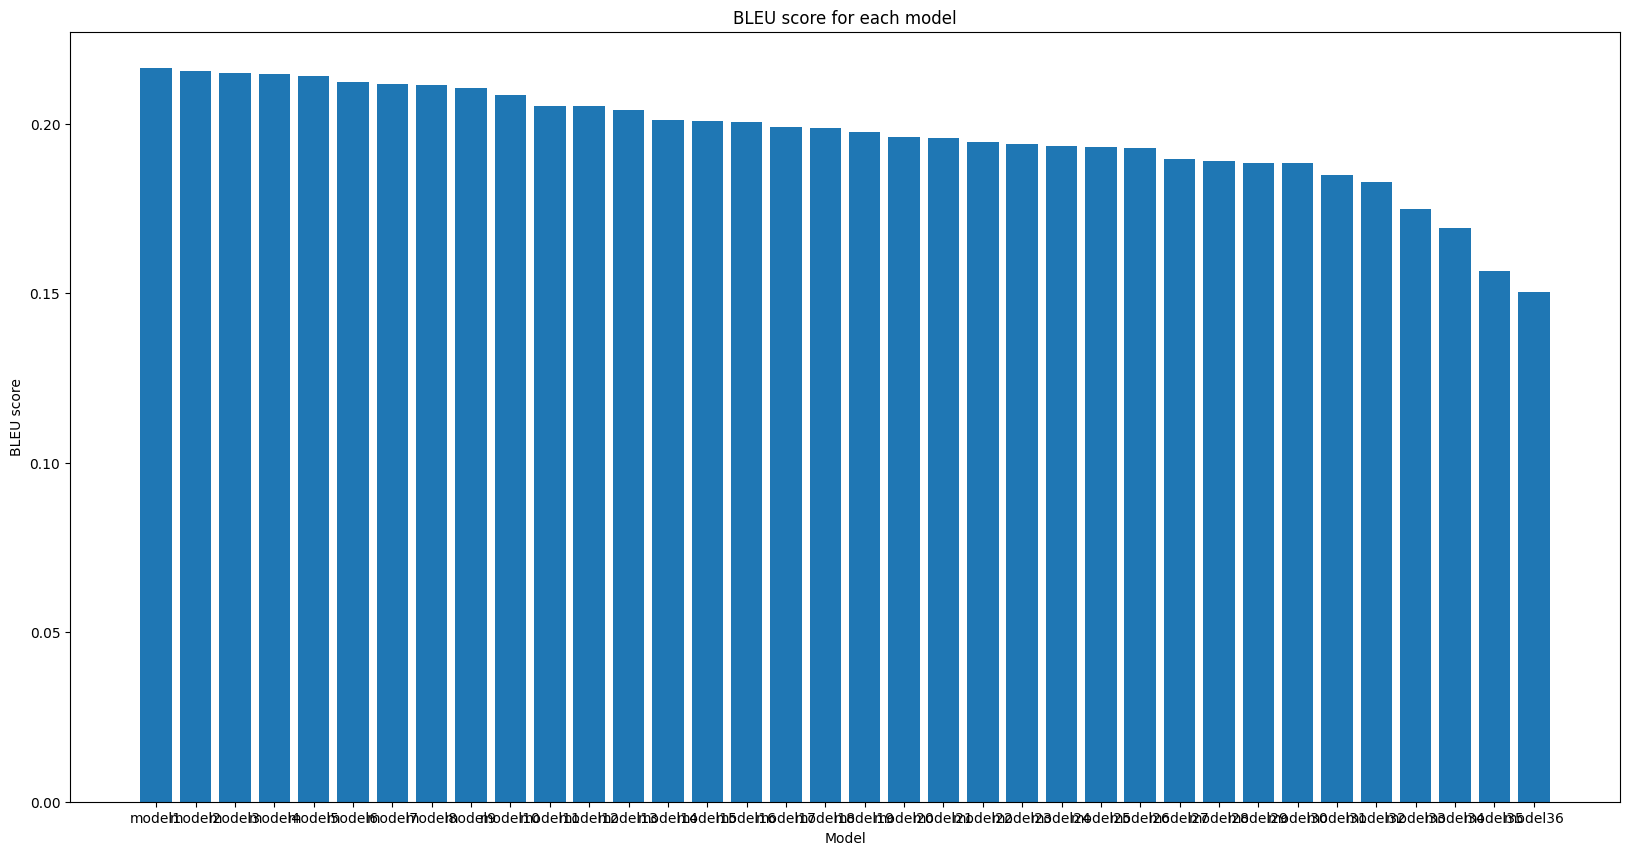

| Model | BLEU Score | Encoder | Tokenizer | Embedding | Dropout | Num Layers | 
| --- | --- | --- | --- | --- | --- | --- | 
|model1 |0.2162757956408899 | vgg19 | text_vectorization | embedding_38  | 0.3 | 2 | 
|model2 |0.21536806848575268 | vgg16 | text_vectorization | embedding_12  | 0.5 | 3 | 
|model3 |0.214982971871725 | vgg19 | text_vectorization | embedding_38  | 0.3 | 3 | 
|model4 |0.21465876264952097 | vgg19 | text_vectorizationTrainable | None  | 0.5 | 4 | 
|model5 |0.21396405351002704 | vgg19 | text_vectorization | embedding_37  | 0.5 | 3 | 
|model6 |0.21217796850295365 | vgg19 | text_vectorizationTrainable | None  | 0.3 | 2 | 
|model7 |0.211807483358104 | vgg16 | text_vectorization | embedding_11  | 0.3 | 4 | 
|model8 |0.21135342424448345 | vgg16 | text_vectorizationTrainable | None  | 0.3 | 4 | 
|model9 |0.21043981108083992 | vgg16 | text_vectorizationTrainable | None  | 0.5 | 3 | 
|model10 |0.20853204020133434 | vgg19 | text_vectorizationTrainable | None  | 0.5 | 3 | 
|model11 |0.2051431546864272 | vgg19 | text_vectorizationTrainable | None  | 0.3 | 3 | 
|model12 |0.2050445839096188 | vgg19 | text_vectorizationTrainable | None  | 0.3 | 4 | 
|model13 |0.20400328802234405 | vgg16 | text_vectorizationTrainable | None  | 0.3 | 3 | 
|model14 |0.20092593451713148 | vgg16 | text_vectorizationTrainable | None  | 0.5 | 2 | 
|model15 |0.20086202553982535 | vgg19 | text_vectorization | embedding_37  | 0.3 | 3 | 
|model16 |0.20050462717546416 | vgg16 | text_vectorization | embedding_11  | 0.3 | 2 | 
|model17 |0.19900081172485448 | vgg16 | text_vectorization | embedding_12  | 0.3 | 2 | 
|model18 |0.19868961434492532 | vgg16 | text_vectorization | embedding_11  | 0.5 | 4 | 
|model19 |0.19737232640070096 | vgg19 | text_vectorizationTrainable | None  | 0.5 | 2 | 
|model20 |0.1959923628261721 | vgg16 | text_vectorizationTrainable | None  | 0.3 | 2 | 
|model21 |0.19583060634582322 | vgg19 | text_vectorization | embedding_38  | 0.5 | 3 | 
|model22 |0.1944909035084291 | vgg16 | text_vectorizationTrainable | None  | 0.5 | 4 | 
|model23 |0.19383222171745293 | vgg19 | text_vectorization | embedding_37  | 0.3 | 4 | 
|model24 |0.19337411945301608 | vgg19 | text_vectorization | embedding_37  | 0.5 | 4 | 
|model25 |0.1929859604691001 | vgg19 | text_vectorization | embedding_38  | 0.5 | 4 | 
|model26 |0.19286757123107257 | vgg16 | text_vectorization | embedding_11  | 0.5 | 2 | 
|model27 |0.18959914004090175 | vgg19 | text_vectorization | embedding_37  | 0.3 | 2 | 
|model28 |0.18883102152705158 | vgg16 | text_vectorization | embedding_12  | 0.3 | 3 | 
|model29 |0.1884908078954575 | vgg16 | text_vectorization | embedding_11  | 0.3 | 3 | 
|model30 |0.18824998245789396 | vgg19 | text_vectorization | embedding_38  | 0.3 | 4 | 
|model31 |0.18492387558064127 | vgg16 | text_vectorization | embedding_12  | 0.5 | 2 | 
|model32 |0.1827730067809413 | vgg16 | text_vectorization | embedding_12  | 0.5 | 4 | 
|model33 |0.17486688456830213 | vgg16 | text_vectorization | embedding_12  | 0.3 | 4 | 
|model34 |0.16912620966102415 | vgg19 | text_vectorization | embedding_38  | 0.5 | 2 | 
|model35 |0.15666082885080468 | vgg19 | text_vectorization | embedding_37  | 0.5 | 2 | 
|model36 |0.1504544295955735 | vgg16 | text_vectorization | embedding_11  | 0.5 | 3 | 


In [ ]:
REAL_DATA = text_to_parse
REAL_DATA = plotAndSort(REAL_DATA)
returnMarkdown(REAL_DATA)

### Tweaking Droupout and number of Layers More

In [ ]:
dropoutResults = {'BLEU_score-1k-vgg19_text_vectorizationTrainable_0.2_2': 0.20759977221793108, 
'BLEU_score-1k-vgg19_text_vectorizationTrainable_0.3_2': 0.20060092708667127, 
'BLEU_score-1k-vgg19_text_vectorizationTrainable_0.4_2': 0.20412878825084435, 
'BLEU_score-1k-vgg19_text_vectorizationTrainable_0.5_2': 0.19107419012283033, 
'BLEU_score-1k-vgg19_text_vectorizationTrainable_0.8_2': 0.18427113433608538, 
'BLEU_score-1k-vgg19_text_vectorizationTrainable_0.25_1': 0.1596258961166145, 
'BLEU_score-1k-vgg19_text_vectorizationTrainable_0.25_2': 0.19783639218188603, 
'BLEU_score-1k-vgg19_text_vectorizationTrainable_0.25_3': 0.19705884082047972, 
'BLEU_score-1k-vgg19_text_vectorizationTrainable_0.3_1': 0.19496730966958467, 
'BLEU_score-1k-vgg19_text_vectorizationTrainable_0.3_3': 0.21174526224884227, 
'BLEU_score-1k-vgg19_text_vectorizationTrainable_0.35_1': 0.19363416908178935, 
'BLEU_score-1k-vgg19_text_vectorizationTrainable_0.35_2': 0.18317550642836214, 
'BLEU_score-1k-vgg19_text_vectorizationTrainable_0.35_3': 0.20002769756911282}

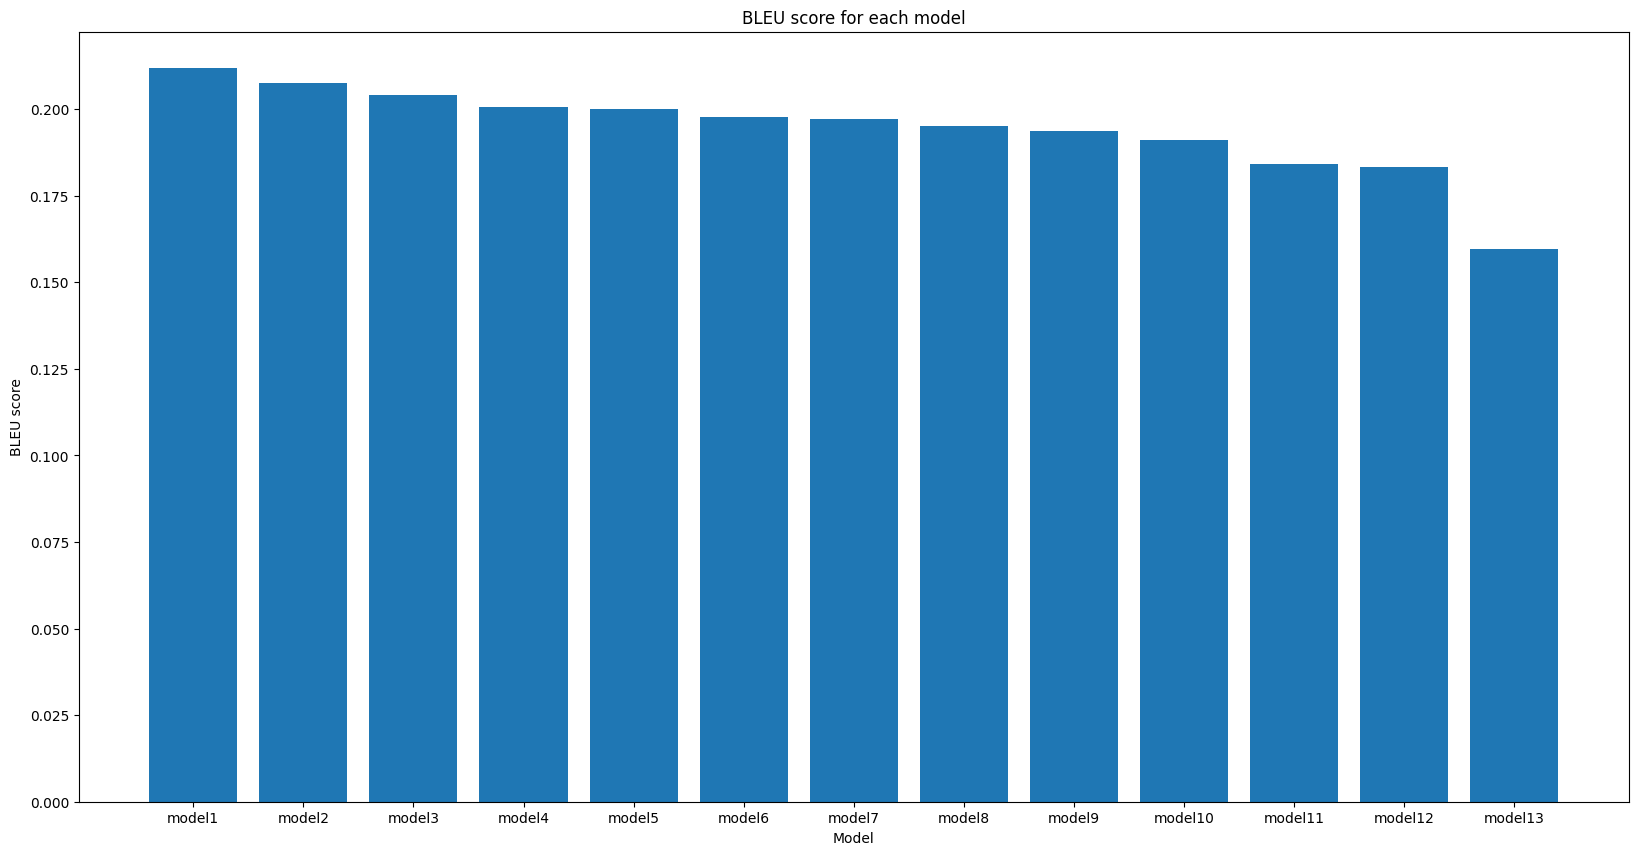

| Model | BLEU Score | Encoder | Tokenizer | Embedding | Dropout | Num Layers | 
| --- | --- | --- | --- | --- | --- | --- | 
|model1 |0.21174526224884227 | vgg19 | text_vectorizationTrainable | None  | 0.3 | 3 | 
|model2 |0.20759977221793108 | vgg19 | text_vectorizationTrainable | None  | 0.2 | 2 | 
|model3 |0.20412878825084435 | vgg19 | text_vectorizationTrainable | None  | 0.4 | 2 | 
|model4 |0.20060092708667127 | vgg19 | text_vectorizationTrainable | None  | 0.3 | 2 | 
|model5 |0.20002769756911282 | vgg19 | text_vectorizationTrainable | None  | 0.35 | 3 | 
|model6 |0.19783639218188603 | vgg19 | text_vectorizationTrainable | None  | 0.25 | 2 | 
|model7 |0.19705884082047972 | vgg19 | text_vectorizationTrainable | None  | 0.25 | 3 | 
|model8 |0.19496730966958467 | vgg19 | text_vectorizationTrainable | None  | 0.3 | 1 | 
|model9 |0.19363416908178935 | vgg19 | text_vectorizationTrainable | None  | 0.35 | 1 | 
|model10 |0.19107419012283033 | vgg19 | text_vectorizationTrainable | None  | 0.5 | 2 | 
|model11 |0.18427113433608538 | vgg19 | text_vectorizationTrainable | None  | 0.8 | 2 | 
|model12 |0.18317550642836214 | vgg19 | text_vectorizationTrainable | None  | 0.35 | 2 | 
|model13 |0.1596258961166145 | vgg19 | text_vectorizationTrainable | None  | 0.25 | 1 | 


In [ ]:
dropoutResults = plotAndSort(dropoutResults)
returnMarkdown(dropoutResults)


### Best Vgg Results


In [ ]:
testingResults2 = {'BLEU_score-1k-vgg19_text_vectorization_2Trainable_0.3_2': 0.2151121909089041,
                    'BLEU_score-1k-vgg19_text_vectorization_2Trainable_0.3_4': 0.21967035024408138,
                    'BLEU_score-1k-vgg19_text_vectorizationTrainable_0.3_2': 0.1912241006371819,
                    'BLEU_score-1k-vgg19_text_vectorizationTrainable_0.3_4': 0.21222363685395865}

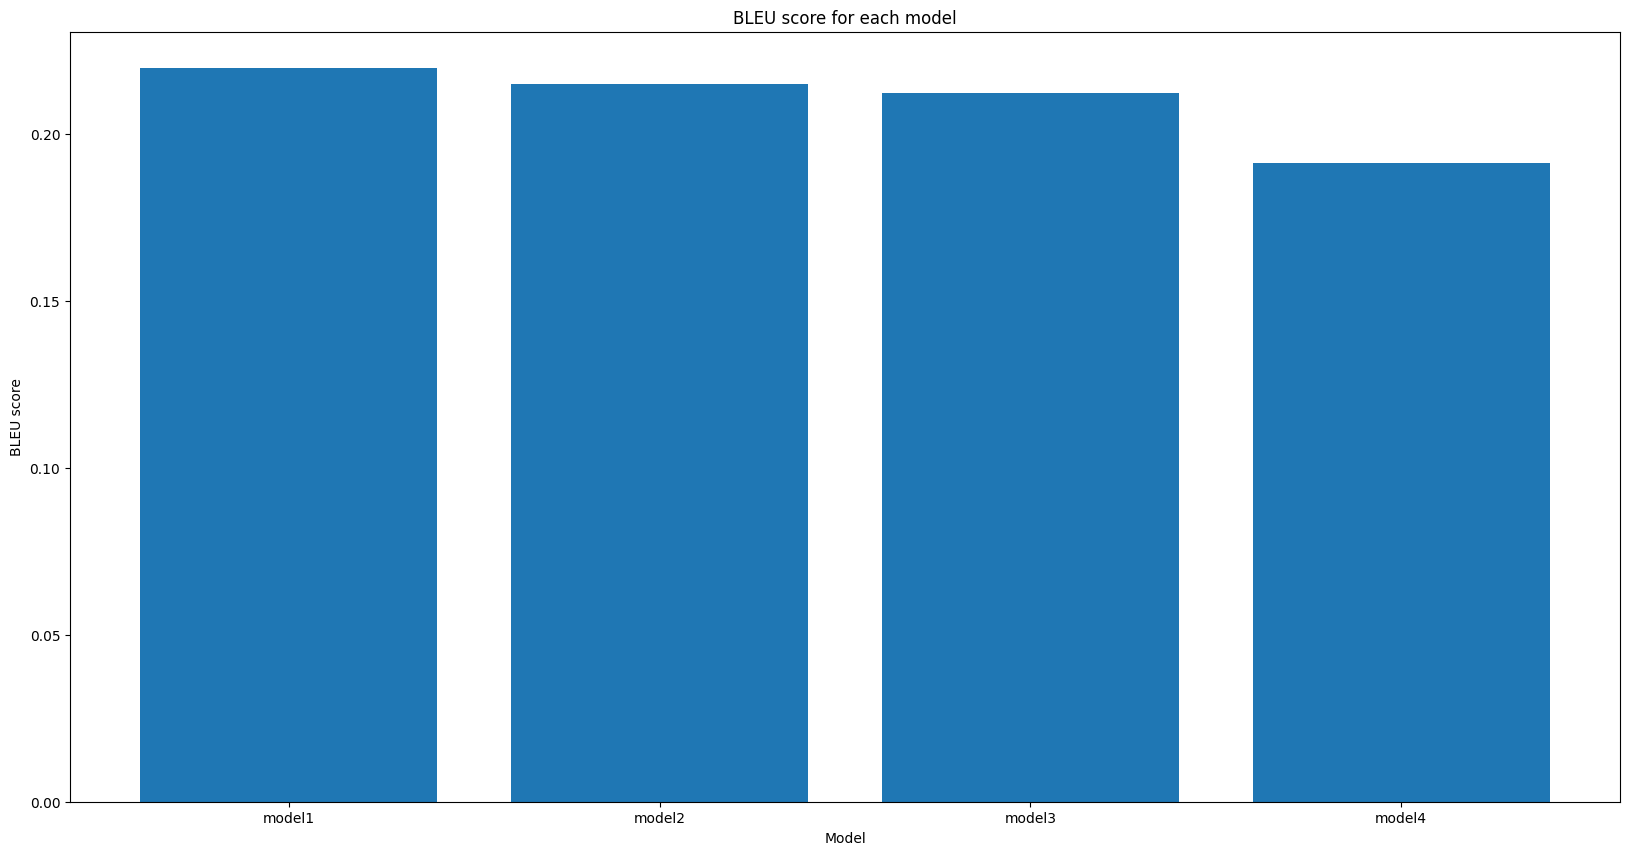

| Model | BLEU Score | Encoder | Tokenizer | Embedding | Dropout | Num Layers | 
| --- | --- | --- | --- | --- | --- | --- | 
|model1 |0.21967035024408138 | vgg19 | text_vectorization | None  | 0.3 | 4 | 
|model2 |0.2151121909089041 | vgg19 | text_vectorization | None  | 0.3 | 2 | 
|model3 |0.21222363685395865 | vgg19 | text_vectorizationTrainable | None  | 0.3 | 4 | 
|model4 |0.1912241006371819 | vgg19 | text_vectorizationTrainable | None  | 0.3 | 2 | 


In [ ]:
testingResults2 = plotAndSort(testingResults2)
returnMarkdown(testingResults2)

### Fix Model & Tokenizer testing

In [ ]:
tokenizersResults = {
    'BLEU_score-1k-vgg19_text_vectorizationTrainable_0.3_3': 0.18693722285144773,
     'BLEU_score-1k-vgg19_tokenizer10kVocTrainable_0.3_3': 0.04900473638447788,
     'BLEU_score-1k-vgg19_tokenizer2kVocTrainable_0.3_3': 0.057811670806954964,
     'BLEU_score-1k-vgg19_tokenizer7kVocTrainable_0.3_3': 0.06524036975871482
}

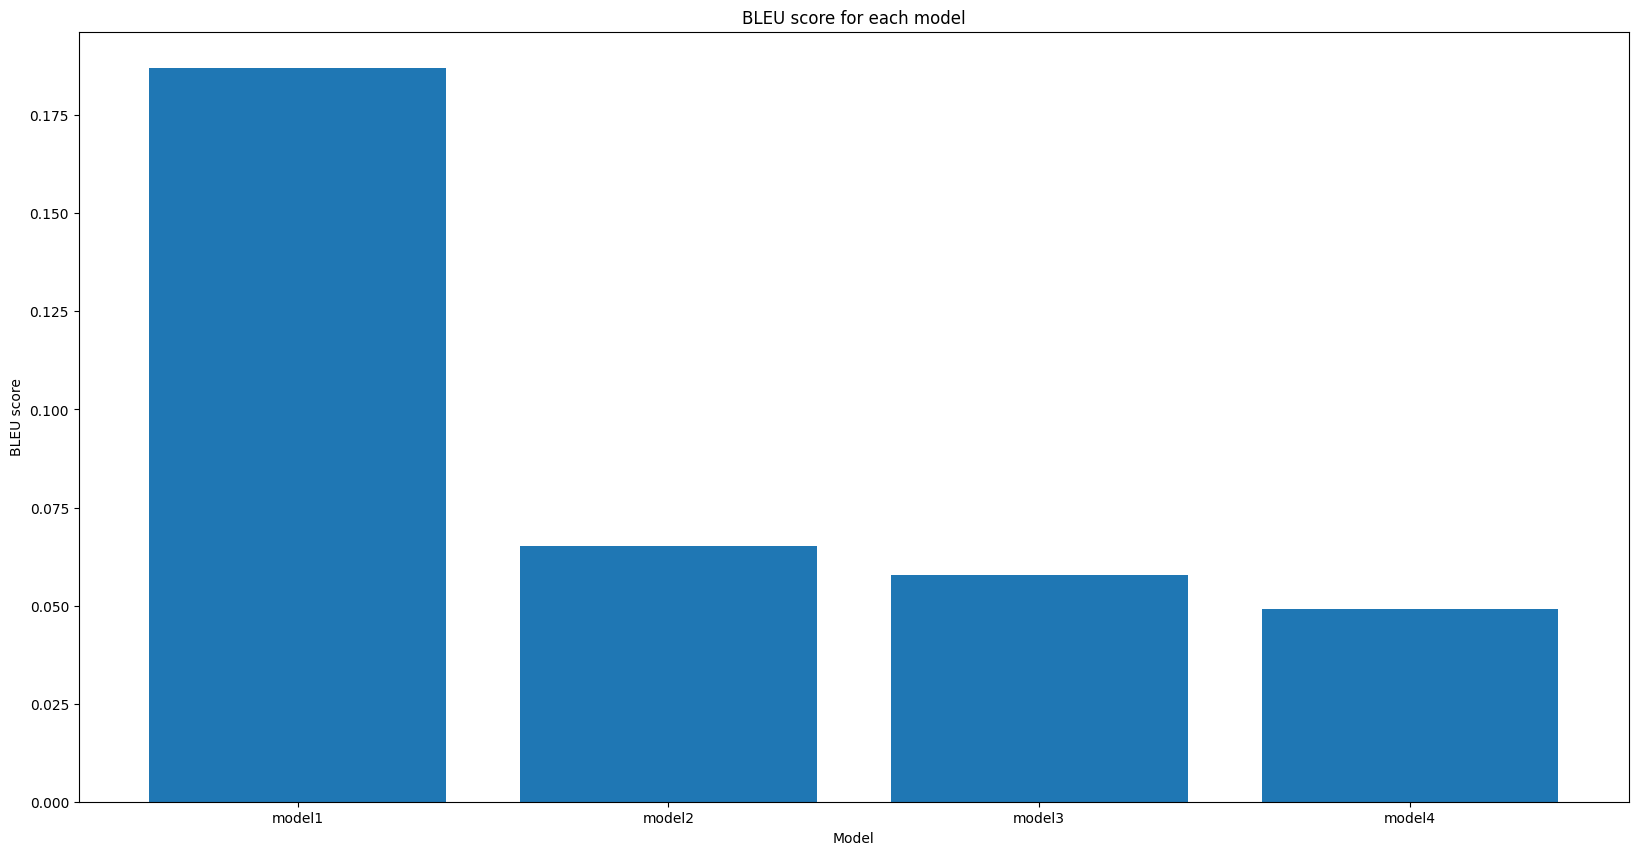

| Model | BLEU Score | Encoder | Tokenizer | Embedding | Dropout | Num Layers | 
| --- | --- | --- | --- | --- | --- | --- | 
|model1 |0.18693722285144773 | vgg19 | text_vectorizationTrainable | None  | 0.3 | 3 | 
|model2 |0.06524036975871482 | vgg19 | tokenizer7kVocTrainable_0.3 | None  | 0.3 | 3 | 
|model3 |0.057811670806954964 | vgg19 | tokenizer2kVocTrainable_0.3 | None  | 0.3 | 3 | 
|model4 |0.04900473638447788 | vgg19 | tokenizer10kVocTrainable_0.3 | None  | 0.3 | 3 | 


In [ ]:
tokenizersResults = plotAndSort(tokenizersResults)
returnMarkdown(tokenizersResults)

### Results without Tokenizer (Trainnable Embeddings)

In [ ]:
results3 = {
 
 'BLEU_score-1k-vgg19_text_vectorizationTrainable_0.3_2': 0.1912241006371819,
 'BLEU_score-1k-vgg19_text_vectorizationTrainable_0.3_4': 0.21222363685395865,
 'BLEU_score-1k-vgg19_text_vectorizationTrainable_0.3_8': 0.19706913680134214
 
}


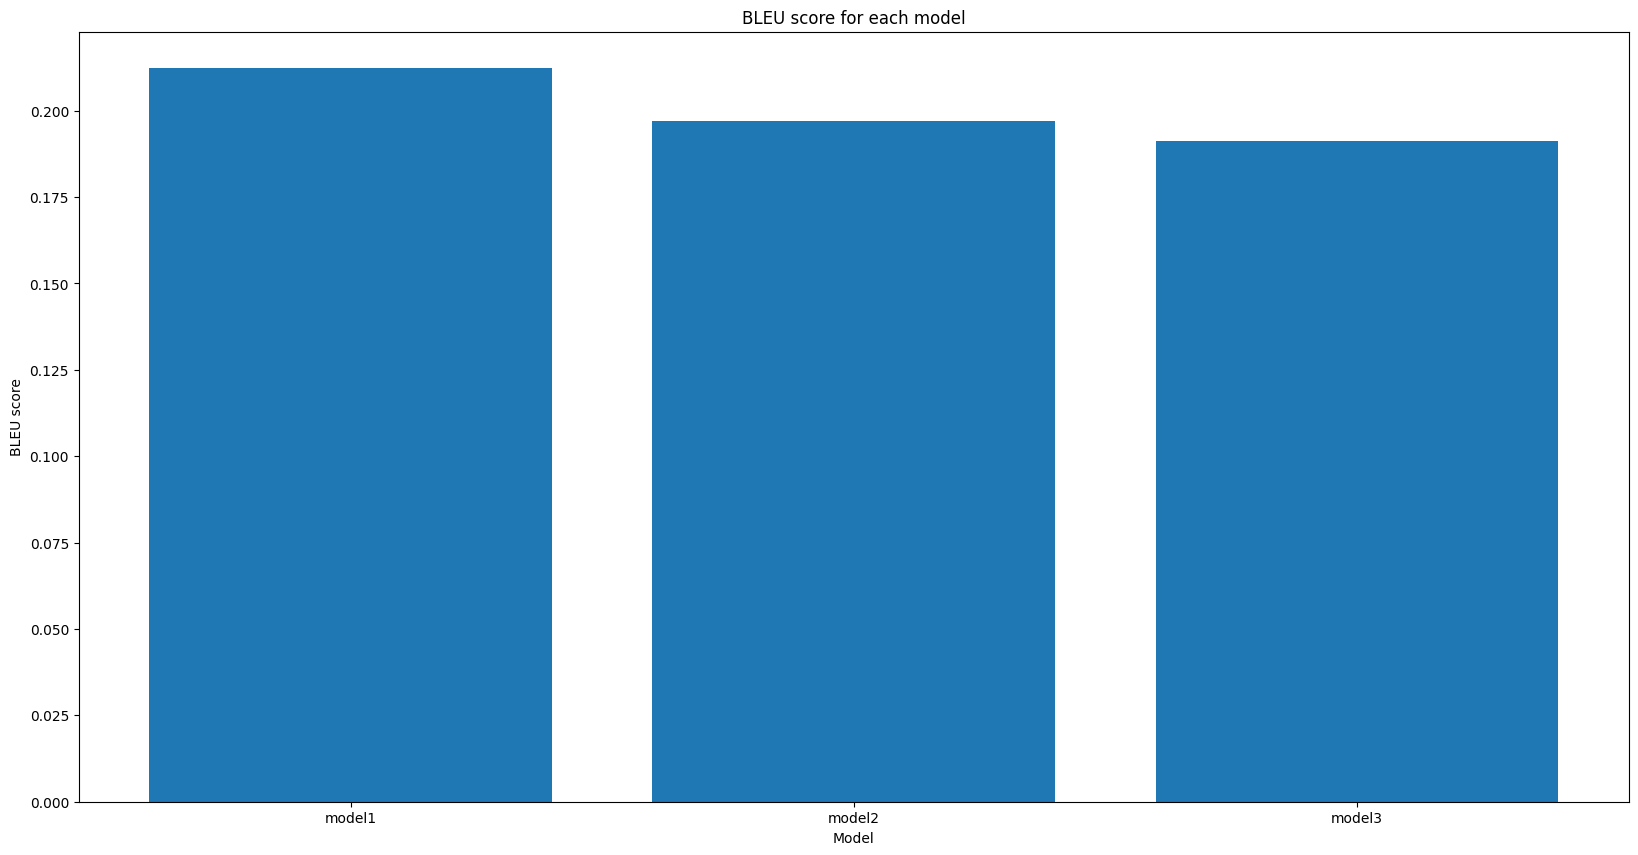

| Model | BLEU Score | Encoder | Tokenizer | Embedding | Dropout | Num Layers | 
| --- | --- | --- | --- | --- | --- | --- | 
|model1 |0.21222363685395865 | vgg19 | text_vectorizationTrainable | None  | 0.3 | 4 | 
|model2 |0.19706913680134214 | vgg19 | text_vectorizationTrainable | None  | 0.3 | 8 | 
|model3 |0.1912241006371819 | vgg19 | text_vectorizationTrainable | None  | 0.3 | 2 | 


In [ ]:
results3 = plotAndSort(results3)
returnMarkdown(results3)

### Switching to more powerful Encoders
<!-- 256 units , 4 heads, 2 layers, 0.25 dropout, tokenizer -> default -->

EfficientNetV2L

In [ ]:
resultsA = {
    'BLEU_score-1k-efficientnetv2-m_text_vectorizationTrainable_0.25_2': 0.2452154366418221,
    'BLEU_score-1k-efficientnetv2-m_text_vectorizationTrainable_0.25_4': 0.23188334205960365
}

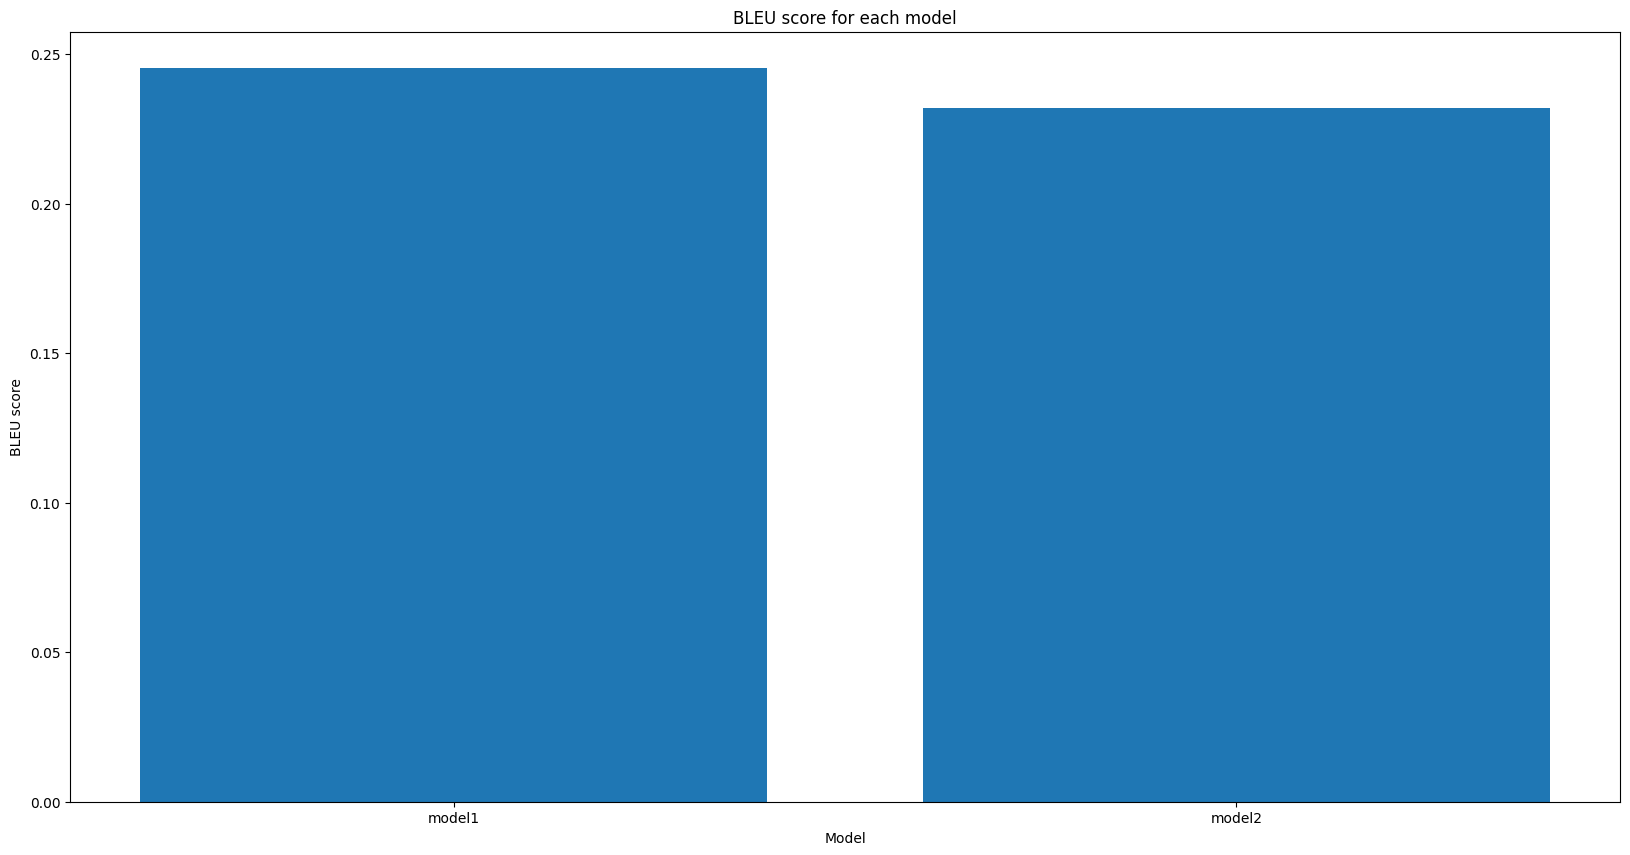

| Model | BLEU Score | Encoder | Tokenizer | Embedding | Dropout | Num Layers | 
| --- | --- | --- | --- | --- | --- | --- | 
|model1 |0.2452154366418221 | efficientnetv2-m | text_vectorizationTrainable | None  | 0.25 | 2 | 
|model2 |0.23188334205960365 | efficientnetv2-m | text_vectorizationTrainable | None  | 0.25 | 4 | 


In [ ]:
resultsA = plotAndSort(resultsA)
returnMarkdown(resultsA)

### Even More Powerful Encoders
UNITS - 256

dropout - 0.25

tokenizer - default

heads - 4

decoder layers - 2


In [ ]:
resultX= {
    'BLEU_score-1k-convnextLarge_text_vectorizationTrainable_0.25_2': 0.2983574348672175,
    'BLEU_score-1k-convnextXlarge_text_vectorizationTrainable_0.25_2': 0.2998262111989321,
    'BLEU_score-1k-convnext_xlarge_text_vectorizationTrainable_0.25_2': 0.3040560200091487
}

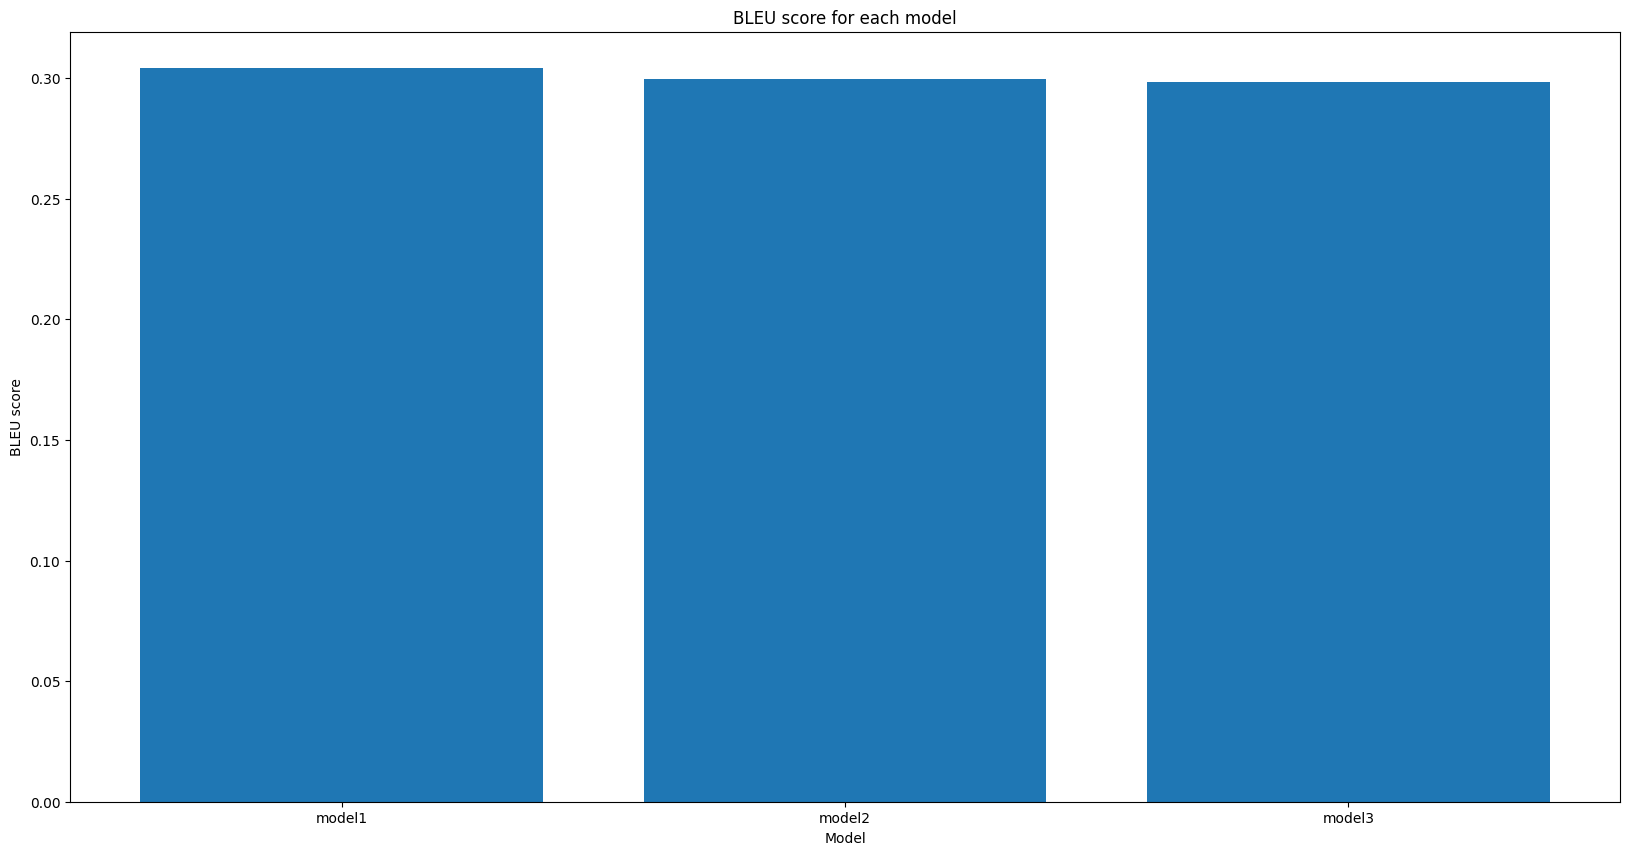

| Model | BLEU Score | Encoder | Tokenizer | Embedding | Dropout | Num Layers | 
| --- | --- | --- | --- | --- | --- | --- | 
|model1 |0.3040560200091487 | convnext | xlarge_text | None  | 0.25 | 2 | 
|model2 |0.2998262111989321 | convnextXlarge | text_vectorizationTrainable | None  | 0.25 | 2 | 
|model3 |0.2983574348672175 | convnextLarge | text_vectorizationTrainable | None  | 0.25 | 2 | 


In [ ]:
resultX = plotAndSort(resultX)
returnMarkdown(resultX)

## Best Model

In [66]:
MAX_EPOCHS = 200 
MAX_PATIENCE = 15

BLEU_SCORE_EVALUATION_LENGTH = 1024

In [68]:
# Blue Score object to keep results from the run function below
bleuScore = BLEUScoreClass(test_data=(test_captions), model=None)

In [69]:
def run2(tokenizers, encoders, embeddings, dropouts, num_layers):
  
  for encoder in encoders:
    for tokenizer in tokenizers:
      
      DATASET_UNIQUE_NAME = encoder.name + '_' + tokenizer.name # include emb, dec_parameters, yesNoBeamSearch
    
      # Use train_raw_capped which has a better window of 
      save_dataset(train_raw_capped, 'train_cache_'+DATASET_UNIQUE_NAME, encoder, tokenizer) # 2.4 min
      save_dataset(test_raw, 'test_cache_'+DATASET_UNIQUE_NAME, encoder, tokenizer) # 40 sec
       
      train_ds = load_dataset('./train_cache_' + DATASET_UNIQUE_NAME)
      test_ds = load_dataset('./test_cache_'+ DATASET_UNIQUE_NAME)

      
      units = 256
      #
      # This is Done Here in Order to fix the correspondance Word -> Vector Embedding that is incorrect
      # Beetween the correspondance Word -> Token -> Vector Embedding from the loaded model
      #
      embeddingsLayers = list(map(lambda model: gensim_to_keras_embedding(tokenizer, model) if model != None else None, embeddings))
      
      for embeddingsLayer in embeddingsLayers:  
        for dropout in dropouts:
          for num_layer in num_layers:
            if embeddingsLayer != None:
              units = embeddingsLayer.output_dim 

              # Build The Output Layer
            output_layer = TokenOutput(tokenizer, banned_tokens=('', '[UNK]', '[START]'))
            output_layer.adapt(train_ds.map(lambda inputs, labels: labels))


            modelEncoder = Captioner(tokenizer, feature_extractor=encoder, output_layer=output_layer,
                        units=units, dropout_rate=dropout, num_layers=num_layer, num_heads=4, embeddings=embeddingsLayer)
            callbacksEncoder = [
            GenerateText(),
            tf.keras.callbacks.EarlyStopping(
                patience=MAX_PATIENCE, restore_best_weights=True)]
            
            modelEncoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                    loss=masked_loss,
                    metrics=[masked_acc,], )
            #
            # fit for about 6 min for each encoder
            #
            historyEncoder = modelEncoder.fit(
              train_ds.repeat(),
              steps_per_epoch=100,
              validation_data=test_ds.repeat(),
              validation_steps=20,
              epochs=MAX_EPOCHS,
              callbacks=callbacksEncoder)
            

            #
            # Fix the name to include all the parameters
            # and ADD BEAM SEARCH EVALUATION OR INTERNALLY IN CALCULATE BLUE SCORE FOR 1K
            # 
            bleuScore.model = modelEncoder
            bleuScore.test_data = test_raw
            bleuScore.calculate_bleu_score_batched(test_raw, nameId=DATASET_UNIQUE_NAME+(embeddingsLayer.name if embeddingsLayer != None else 'Trainable')+'_'+str(dropout)+'_'+str(num_layer))
            print(bleuScore.logs)

      # DELETE THE CACHED STUFF FOR NEXT LOOP so colab doesn't fill
      # !rm -rf {'train_cache_'+DATASET_UNIQUE_NAME}
      # !rm -rf {'test_cache_'+DATASET_UNIQUE_NAME}
  return modelEncoder, bleuScore 
        

In [70]:
model, blueScoreResults = run2([tokenizers[0]], [convNeXtXLarge], [None], dropouts=[0.25], num_layers=[2])

456it [12:07,  1.60s/it]
142it [03:46,  1.59s/it]
100%|██████████| 2278/2278 [01:59<00:00, 19.02it/s] 



Uniform entropy: 8.52
Marginal entropy: 5.44
Epoch 1/200
 99/100 [============================>.] - ETA: 0s - loss: 5.0317 - masked_acc: 0.2116

a man in a man
a woman in a the boy on a man
two group older halter girl on a running in the trees concrete

100/100 [==============================] - 40s 256ms/step - loss: 5.0303 - masked_acc: 0.2119 - val_loss: 4.9201 - val_masked_acc: 0.2385
Epoch 2/200
100/100 [==============================] - ETA: 0s - loss: 4.6309 - masked_acc: 0.2664

a man in a blue shirt is is in a blue
a man in a the shirt is in a man in a white a young man
the man lady on a on two on the puck of the people lady

100/100 [==============================] - 13s 127ms/step - loss: 4.6309 - masked_acc: 0.2664 - val_loss: 4.5789 - val_masked_acc: 0.2619
Epoch 3/200
 99/100 [============================>.] - ETA: 0s - loss: 4.4412 - masked_acc: 0.2852

a man in a blue shirt is is sitting on a blue
a man is sitting playing a man in the man
a black female is holding the 

32it [02:23,  4.48s/it]


Count is 1024
{'BLEU_score-1k-convnext_xlarge_text_vectorizationTrainable_0.25_2': 0.3040560200091487}


In [71]:
BestModel = model
BestModel.summary()

Model: "captioner"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 convnext_xlarge (Functional  (None, 7, 7, 2048)       348147968 
 )                                                               
                                                                 
 text_vectorization (TextVec  multiple                 0         
 torization)                                                     
                                                                 
 string_lookup_5 (StringLook  multiple                 0         
 up)                                                             
                                                                 
 string_lookup_6 (StringLook  multiple                 0 (unused)
 up)                                                             
                                                                 
 seq_embedding (SeqEmbedding  multiple                 12

In [ ]:
BestModel.save('/content/BestModel/')

In [ ]:
!zip -r BestModel.zip BestModel

Evaluation on test set with Beam Search Generation of 1000 Samples

In [77]:
bleuScore = BLEUScoreClass(test_data=(test_captions), model=BestModel)
bleuScore.corpus_bleu_bs()
bleuScore.logs

100%|██████████| 1000/1000 [32:01<00:00,  1.92s/it]


{'BLEU_score-1k-default': 0.3164799579055236}

### Some Results On Images

Παρατηρούμε σε κάποιες εικόνες να μπορεί να βρει βασικά χαρακτηριστικά και να τα αποτυπώσει αλλά να δυσκολεύεται να εντοπίσει περισσότερες λεπτομέρειες.

Prediction : 
 a black and white dog is jumping in front of trees
Captions  : 
 [b'a black and white dog wearing a blue shirt carrying a toy in its mouth .'
 b'A brown dog with a blue suit on is playing with a toy over fake grass .'
 b'A dog in a blue sweater leaps while holding an object in its mouth .'
 b'The black dog is wearing a blue jacket and playing with a toy .'
 b'A dog wearing a blue sweater holds a yellow toy in its mouth .']


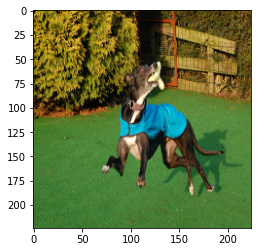

In [113]:
for img, captions in test_raw.take(1):
  break
test_img = load_image(img)[tf.newaxis, :].numpy()[0]
res = BestModel.simple_gen_beam_search(test_img)
# print(img.numpy().decode())
print(f'Prediction : \n {res}')
print(f'Captions  : \n {captions}')

plt.imshow(test_img/255)
plt.show()

Prediction : 
 a woman in a black shirt stands in front of a crowd
Captions  : 
 [b'A Latino woman is standing outside raising her arm with a band playing in the background .'
 b'A Latin woman raising her hand in front of a band in the background .'
 b'A woman wearing a brown flowered dress is raising her hand .'
 b'A woman with curly hair is raising her hand on a street .'
 b'A woman dances next to a stage during a music festival .']


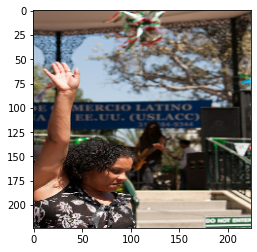

In [112]:
for img, captions in test_raw.take(4):
  continue
test_img = load_image(img)[tf.newaxis, :].numpy()[0]
res = BestModel.simple_gen_beam_search(test_img)
# print(img.numpy().decode())
print(f'Prediction : \n {res}')
print(f'Captions  : \n {captions}')

plt.imshow(test_img/255)
plt.show()

Σε κάποιες άλλες πετυχαίνει λιγότερες λεπτομέρειες

Prediction : 
 a woman in a pink shirt and blue jeans is standing in front of a pink bucket
Captions  : 
 [b'A small child playing with a toy oven in a mock kitchen at home .'
 b'A toddler is opening the oven door of a pink play kitchen set .'
 b'A child plays with a pink kitchen set that is child-sized .'
 b'A young girl plays in her pink toy kitchen .'
 b'A little girl playing with kitchen toys .']


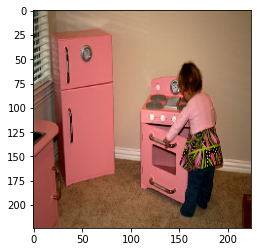

In [111]:
for img, captions in test_raw.take(8):
  continue
test_img = load_image(img)[tf.newaxis, :].numpy()[0]
res = BestModel.simple_gen_beam_search(test_img)
# print(img.numpy().decode())
print(f'Prediction : \n {res}')
print(f'Captions  : \n {captions}')

plt.imshow(test_img/255)
plt.show()

Στην παρακάτω τα πάει αρκετά καλά παρά τις λίγες χρωματικές διαφορές

Prediction : 
 a white dog is walking through the snow
Captions  : 
 [b'The white and brown dog leaps into the air , above snow covered ground .'
 b'A brown and white dog jumps in the air to catch a snowball .'
 b'Dog jumping to catch falling snow out in the woods .'
 b'A black and white dog is leaping from a snowy path .'
 b'A dog jumps up and tries to catch a lump of snow .']


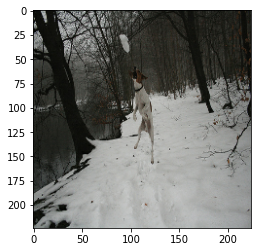

In [110]:
for img, captions in test_raw.take(124):
  continue
test_img = load_image(img)[tf.newaxis, :].numpy()[0]
res = BestModel.simple_gen_beam_search(test_img)
# print(img.numpy().decode())
print(f'Prediction : \n {res}')
print(f'Captions  : \n {captions}')

plt.imshow(test_img/255)
plt.show()

Σε κάποιες άλλες είναι λιτό αλλά κατά την γνώμη μας ικανοποιητικό

Prediction : 
 two children are riding on a swing
Captions  : 
 [b'Two girls ride a swing ride at a fair or amusement park wearing flip-flops and tank tops .'
 b'Two girls with flip-flops are riding on a flying swings ride .'
 b'Two girls are on the swing ride at an amusement park .'
 b'Women on a swing ride at an amusement park .'
 b'Two women are swinging in a carnival ride .']


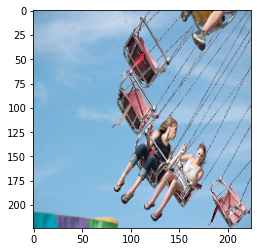

In [120]:
for img, captions in test_raw.take(134):
  continue
test_img = load_image(img)[tf.newaxis, :].numpy()[0]
res = BestModel.simple_gen_beam_search(test_img)
# print(img.numpy().decode())
print(f'Prediction : \n {res}')
print(f'Captions  : \n {captions}')

plt.imshow(test_img/255)
plt.show()

Prediction : 
 a woman wearing sunglasses and a plaid shirt is looking at the camera
Captions  : 
 [b'A fair-skinned woman with dark hair wears a pair of large dark sunglasses , crimson lipstick , and a red and white plaid shirt .'
 b'A woman with bright red lipstick , sunglasses and a red plaid shirt is looking towards the camera .'
 b'A lady wearing black sunglasses frowning as she stares at something .'
 b'A lady with big glasses is looking at something .'
 b'A woman with sunglasses and a plaid shirt .']


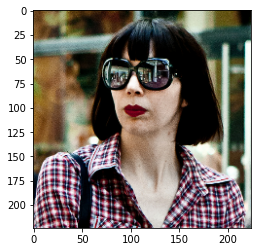

In [121]:
for img, captions in test_raw.take(131):
  continue
test_img = load_image(img)[tf.newaxis, :].numpy()[0]
res = BestModel.simple_gen_beam_search(test_img)
# print(img.numpy().decode())
print(f'Prediction : \n {res}')
print(f'Captions  : \n {captions}')

plt.imshow(test_img/255)
plt.show()